# **Dataset**


https://github.com/SenticNet/stress-detection


# **Import Dependencies**


In [ ]:
# General Purpose Packages
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from collections import Counter


# Data Preprocessing
import re, string
import nltk
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
import tarfile
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer

# Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

# Transformers
import transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

# Keras
from tensorflow import keras

# Metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

# **Bussiness Understanding**

**Identifikasi Masalah**

1. Stres adalah keadaan khawatir atau ketegangan mental yang disebabkan oleh situasi sulit.
2. Media sosial menjadi tempat bagi seorang individu untuk mengungkapkan beragam emosi positif ataupun emosi negatif.

**Deskripsi Masalah**

1. Stres  dapat disebabkan oleh pekerjaan, peristiwa kehidupan, dan faktor pribadi.
2. Tingkat stres yang sedikit dapat membantu performa kehidupan, namun terlalu banyak stress dapat menyebabkan masalah kesehatan fisik dan mental.


**Tujuan**

Mengembangkan metode yang tepat untuk melakukan deteksi dini pada stres dari postingan di media sosial agar seorang individu yang berisiko mengalami masalah kesehatan fisik dan mental karena stres dapat mendapatkan dukungan dan intervensi tepat waktu

**Target**

Meningkatkan akurasi hasil prediksi label stres dari algoritma roBERTa terhadap data postingan di Twitter dan Reddit

**Stakeholder**

1. Pengguna media sosial
2. Platform media sosial
3. Lembaga kesehatan mental
4. Pemerintah
5. Peneliti


# **Analytic Approach**

Menggunakan pendekatan prediktif dengan menggunakan Supervised Learning Classification melalui Algoritma RoBERTa

# **Data Requirement**


Membutuhkan setidaknya dua dataset dari platform media sosial berbeda (Twitter dan Reddit)

Membutuhkan kolom fitur postingan pengguna media sosial dan kolom label (Stress positive / stress negative)

# **Data Collection**

Penelitian menggunakan dataset sekunder yang merupakan public data dan terserdia pada github.

Dataset diambil dari https://github.com/SenticNet/stress-detection yang memiliki 4 file excel (Reddit_Combi.xlsx, Reddit_Title.xlsx, Twitter_Full.xlsx, dan Twitter_Non-Advert.xlsx).

Dataset yang akan digunakan adalah file Reddit_Combi.xlsx dan file Twitter_Non-Advert.xlsx.

In [ ]:
!git clone https://github.com/SenticNet/stress-detection.git

fatal: destination path 'stress-detection' already exists and is not an empty directory.


In [ ]:
# Convert Reddit Combi and Twitter_Non-Advert Excel to Dataframe
reddit = pd.DataFrame(pd.read_excel('/content/stress-detection/Reddit_Combi.xlsx'))
twitter = pd.DataFrame(pd.read_excel('/content/stress-detection/Twitter_Non-Advert.xlsx'))

In [ ]:
# Show twt dataframe.head()
twitter.head(5)

text  label
0   speak-no-evil monkey Can I Be Honest With You...      1
1  Frau Goebbels early signs of psychosis psychot...      1
2  A lot of work and unfulfilled tasks plunge you...      1
3  Private health insurance delivers value for yo...      1
4  XpertOnline offers you the convenience of view...      1

In [ ]:
# Show reddit dataframe.head()
reddit.sample(5)

title  \
1369     My sister is depressed and idk how to help her   
1303  Surfing in reddit makes me more stressed than ...   
1860                                      Being strong.   
1920  It's my cake day of 5 years, and it's a good day!   
1111   Feeling immense guilt and shame about everything   

                                                   body  \
1369  My sister, over the last few weeks, hasn't lef...   
1303  Ever since I visited this place my stress leve...   
1860  Despite the virus shutting everything down, my...   
1920  I've been struggling with covid, a recent brea...   
1111  I’ve been basically drinking myself out of exi...   

                                             Body_Title  label  
1369  My sister is depressed and idk how to help her...      1  
1303  Surfing in reddit makes me more stressed than ...      1  
1860  Being strong. Despite the virus shutting every...      1  
1920  It's my cake day of 5 years, and it's a good d...      0  
1111  Feeling immense guilt and shame about everythi...      1

# **Data Understanding**

## Twitter

### Data Information of Twitter No-Adver

In [ ]:
# Show twt row and column
twitter_shape = twitter.shape
print("Twitter No Adver dataset have ", twitter_shape[0], " rows and ", twitter_shape[1], "column")

Twitter No Adver dataset have  2051  rows and  2 column


In [ ]:
# Show twitter.info()
twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2051 non-null   object
 1   label   2051 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 32.2+ KB


In [ ]:
twitter.describe(include = "all")

text        label
count                                                2051  2051.000000
unique                                               1972          NaN
top     Trigger warning miscarriage and ectopic pregna...          NaN
freq                                                    4          NaN
mean                                                  NaN     0.618235
std                                                   NaN     0.485938
min                                                   NaN     0.000000
25%                                                   NaN     0.000000
50%                                                   NaN     1.000000
75%                                                   NaN     1.000000
max                                                   NaN     1.000000

In [ ]:
# Check Na and Null in twitter_non-Advert
twitter.isna().sum()

text     0
label    0
dtype: int64

In [ ]:
print("Sum of Missing Value in Reddit Combi",twitter.value_counts().isna().sum())

Sum of Missing Value in Reddit Combi 0


In [ ]:
twit_duplicate =twitter.duplicated().sum()
print("Sum of Duplicated Data in Twitter No Adver", twit_duplicate)

Sum of Duplicated Data in Twitter No Adver 79


In [ ]:
# Get Twitter Label Name
twitter_label = twitter['label']
twitter_label = twitter_label.replace({1:"Stress",0:"Tidak Stress"})
twitter_label_unique = twitter_label.unique()
twitter_label_unique

array(['Stress', 'Tidak Stress'], dtype=object)

### Bar-Chart Visualization of Twitter-No-Adver Data

In [ ]:
jumlah_label_twitter = twitter['label'].value_counts()
jumlah_label_twitter

1    1268
0     783
Name: label, dtype: int64

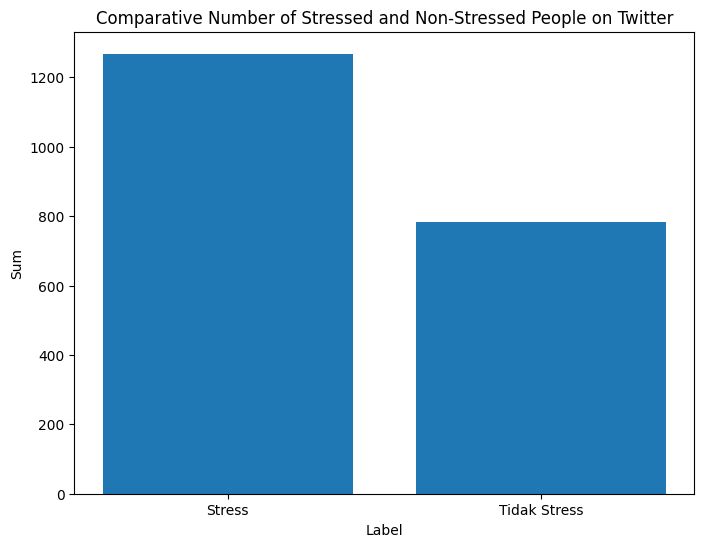

In [ ]:
plt.figure(figsize = (8,6))
plt.bar(twitter_label_unique,jumlah_label_twitter.values)
plt.xlabel('Label')
plt.ylabel('Sum')
plt.title('Comparative Number of Stressed and Non-Stressed People on Twitter')
plt.show()

Berdasarkan hasil visualisasi barchart pada dataset twitter, dapat dilihat bahwa komentar pada platform twitter didominasi oleh komentar dengan label stress. Visualisasi tersebut juga menunjukkan bahwa dataset twitter tidak memiliki kesenjangan label yang signifikan.

### Histogram Visualization of Twitter-No-Adver Data

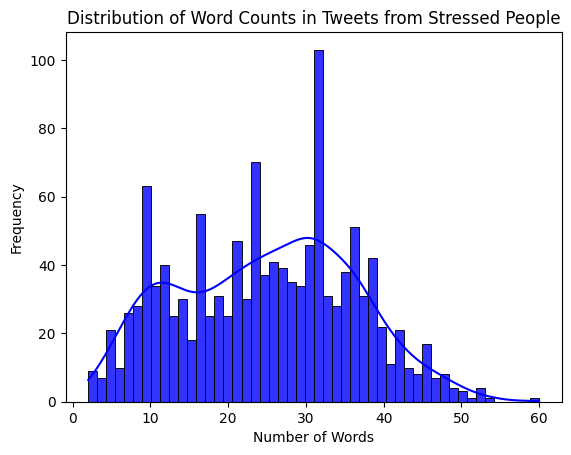

In [ ]:
teks_stress = twitter[twitter['label'] == 1]['text']
twitter_stress = pd.DataFrame({'text': teks_stress})
twitter_stress['text_length'] = twitter_stress['text'].apply(lambda x: len(x.split()))
sns.histplot(twitter_stress['text_length'], bins=50, color='blue',kde = True,alpha = .8)
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts in Tweets from Stressed People')
plt.show()

Berdasarkan hasil visualisasi histogram pada dataset twitter, dapat dilihat bahwa frekuensi komentar dengan label stress tertinggi ada pada komentar yang memiliki kurang lebih 30 kata.

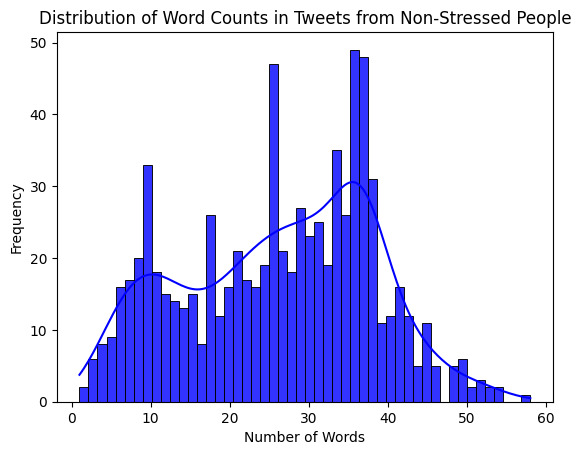

In [ ]:
teks_non_stress = twitter[twitter['label'] == 0]['text']
twitter_non_stress = pd.DataFrame({'text': teks_non_stress})
twitter_non_stress['text_length'] = twitter_non_stress['text'].apply(lambda x: len(x.split()))
sns.histplot(twitter_non_stress['text_length'], bins=50, color='blue',kde = True,alpha=.8)
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts in Tweets from Non-Stressed People')
plt.show()


Berdasarkan hasil visualisasi histogram pada dataset twitter, dapat dilihat bahwa frekuensi komentar dengan label tidak stress tertinggi ada pada komentar yang memiliki kurang lebih 30 - 40 kata.

### Word Cloud of Twitter-No-Adver Data

In [ ]:
twitter[twitter['label']==1]['text']

0        speak-no-evil monkey Can I Be Honest With You...
1       Frau Goebbels early signs of psychosis psychot...
2       A lot of work and unfulfilled tasks plunge you...
3       Private health insurance delivers value for yo...
4       XpertOnline offers you the convenience of view...
                              ...                        
2044    CBCAlerts Being part of the war criminal organ...
2045    Therapy is not only for those who have receive...
2046    Adaptogens like echinacea and turmeric help pr...
2047    Stanford Study Being Kind to Others Improves B...
2049     no mobile phones Three Tips to Reduce Technos...
Name: text, Length: 1268, dtype: object

In [ ]:
twitter[twitter['label']==0]['text']

6       Presenting a short guided meditation by that w...
7       Stressed out? Read on the healthy ways to cope...
9       Key Elements of Good Time Management ... Make ...
12      diversity & uniqueness - celebrating both with...
15      BREAKING HOLLYWOOD NEWS Excited Music NormaJea...
                              ...                        
2037    Friday Motivation...Happy weekend FAM...T G.I....
2038    First day as an Executive Sales and Marketing ...
2039    Made by color sand art relax color foryou pain...
2048    Thank you for all your business questions toda...
2050     police car light New Product Alert! police ca...
Name: text, Length: 783, dtype: object

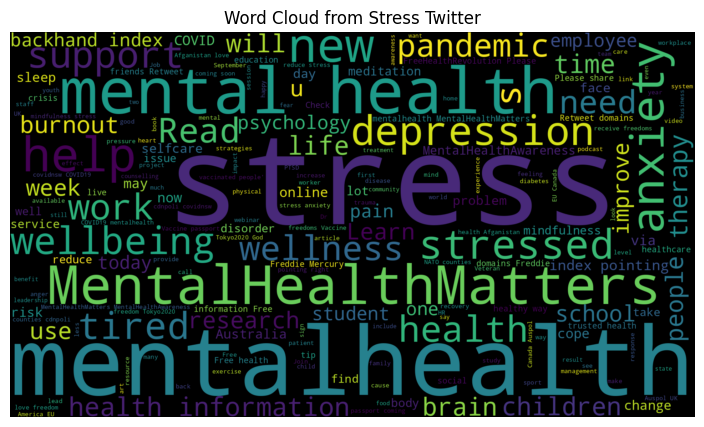

In [ ]:
stopWords = STOPWORDS
all_text_stress_twit = ' '.join(twitter[twitter['label']==1]['text'])
wordcloud_stress_twit = WordCloud(
    background_color = 'black',
    height = 1080,
    width = 1920,
    stopwords = stopWords
)

wordcloud_stress_twit.generate(all_text_stress_twit)
# Display the WordCloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_stress_twit, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud from Stress Twitter')
plt.show()

Berdasarkan hasil visualisasi wordcloud pada dataset twitter, dapat dilihat bahwa kata yang banyak digunakan pada komentar dengan label stress adalah kata stress, help, burnout, dan tired.

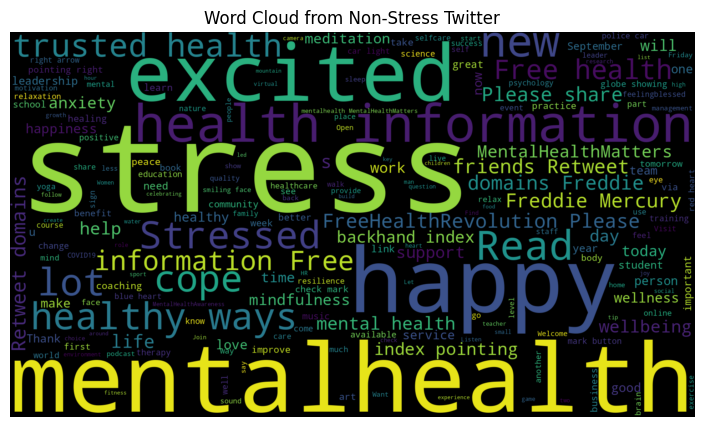

In [ ]:
stopWords = STOPWORDS
all_text_no_stress_twit = ' '.join(twitter[twitter['label']==0]['text'])
wordcloud_no_stress_twit = WordCloud(
    background_color = 'black',
    height = 1080,
    width = 1920,
    stopwords = stopWords
)

wordcloud_no_stress_twit.generate(all_text_no_stress_twit)
# Display the WordCloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_no_stress_twit, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud from Non-Stress Twitter')
plt.show()

Berdasarkan hasil visualisasi wordcloud pada dataset twitter, dapat dilihat bahwa kata yang banyak digunakan pada komentar dengan label tidak stress adalah kata happy, healty, healty information, free health, dan free health revolution.

### Most Frequent Word in Twitter

In [ ]:
import re

def clean_text(text):
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', text)
    return cleaned_text

In [ ]:
words_stress_twitt = all_text_stress_twit.split()
filter_word_stress_twitt = [word for word in words_stress_twitt if word.lower() not in stopWords]
words_stress_freq_twitt = Counter(filter_word_stress_twitt)
word_stress_freq_twitt_df = pd.DataFrame(list(words_stress_freq_twitt.items()), columns=['Word', 'Frequency'])
word_stress_freq_twitt_df = word_stress_freq_twitt_df.sort_values(by='Frequency', ascending=False)

In [ ]:
word_stress_freq_twitt_df

Word  Frequency
19             stress        460
16       mentalhealth        422
54             health        289
148                 &        169
113            Stress        161
...               ...        ...
4348    Psychotherapy          1
4346         project.          1
4345              DIY          1
4343  OneSimpleChange          1
9352     technostress          1

[9353 rows x 2 columns]

In [ ]:
words_no_stress_twitt = all_text_no_stress_twit.split()
filter_word_no_stress_twitt = [word for word in words_no_stress_twitt if word.lower() not in stopWords]
filter_word_no_stress_twitt = Counter(filter_word_no_stress_twitt)
word_no_stress_freq_twitt_df = pd.DataFrame(list(filter_word_no_stress_twitt.items()), columns=['Word', 'Frequency'])
word_no_stress_freq_twitt_df = word_no_stress_freq_twitt_df.sort_values(by='Frequency', ascending=False)

In [ ]:
word_no_stress_freq_twitt_df

Word  Frequency
28           health        195
17     mentalhealth        146
6            stress        135
177           happy        111
11                &         99
...             ...        ...
3094          Dunk,          1
3093         Potter          1
3092  itsgoodtotalk          1
3091            bpd          1
6831        Snapper          1

[6832 rows x 2 columns]

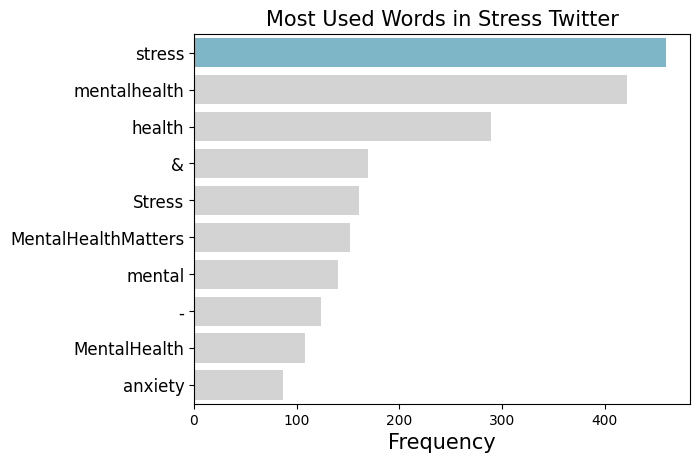

In [ ]:
colors = ["#72BCD4", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3"]
sns.barplot(x="Frequency", y="Word", data=word_stress_freq_twitt_df.head(10), palette=colors)
plt.ylabel(None)
plt.xlabel("Frequency", fontsize=15)
plt.title("Most Used Words in Stress Twitter", fontsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.show()

Berdasarkan hasil visualisasi most used word pada dataset twitter, dapat dilihat bahwa kata yang paling banyak digunakan pada komentar dengan label stress adalah kata stress.

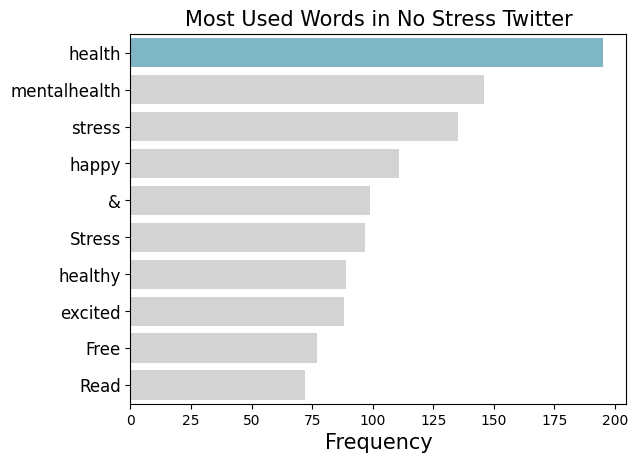

In [ ]:
colors = ["#72BCD4", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3"]
sns.barplot(x="Frequency", y="Word", data=word_no_stress_freq_twitt_df.head(10), palette=colors)
plt.ylabel(None)
plt.xlabel("Frequency", fontsize=15)
plt.title("Most Used Words in No Stress Twitter", fontsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.show()

Berdasarkan hasil visualisasi most used word pada dataset twitter, dapat dilihat bahwa kata yang paling banyak digunakan pada komentar dengan label tidak stress adalah kata health.

## Reddit

### Data Information of Reddit Combi

In [ ]:
# Show Reddit row and column
reddit_shape = reddit.shape
print("Reddit Combi dataset have ", reddit_shape[0], " rows and ", reddit_shape[1], "column")

Reddit Combi dataset have  3123  rows and  4 column


In [ ]:
# Show reddit.info()
reddit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3123 entries, 0 to 3122
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   title       3123 non-null   object
 1   body        3116 non-null   object
 2   Body_Title  3123 non-null   object
 3   label       3123 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 97.7+ KB


In [ ]:
reddit.describe(include = "all")

title                                               body  \
count   3123                                               3116   
unique  3098                                               3112   
top     Help  So I learned 3D designs during quarantine and ...   
freq       3                                                  2   
mean     NaN                                                NaN   
std      NaN                                                NaN   
min      NaN                                                NaN   
25%      NaN                                                NaN   
50%      NaN                                                NaN   
75%      NaN                                                NaN   
max      NaN                                                NaN   

                                               Body_Title        label  
count                                                3123  3123.000000  
unique                                               3123          NaN  
top     Envy to other is swallowing me Im from develop...          NaN  
freq                                                    1          NaN  
mean                                                  NaN     0.878963  
std                                                   NaN     0.326223  
min                                                   NaN     0.000000  
25%                                                   NaN     1.000000  
50%                                                   NaN     1.000000  
75%                                                   NaN     1.000000  
max                                                   NaN     1.000000

In [ ]:
# Check Na dan Null in Reddit Combi
reddit.isna().sum()

title         0
body          7
Body_Title    0
label         0
dtype: int64

In [ ]:
print("Sum of Missing Value in Reddit Combi",reddit.value_counts().isna().sum())

Sum of Missing Value in Reddit Combi 0


In [ ]:
# Sum of Duplicated Value in Reddit Combi
duplicate = reddit.duplicated().sum()
print("Sum of Duplicated Data in Reddit Combi", duplicate)

Sum of Duplicated Data in Reddit Combi 0


### Bar-Chart Visualization of Reddit Combi Data

In [ ]:
# Get Reddit Label Name
label_name = reddit['label']
label_name = label_name.replace({1:'Stress', 0:'Tidak Stress'})
label_name = label_name.unique()
label_name

array(['Stress', 'Tidak Stress'], dtype=object)

In [ ]:
# Count Each Label in Reddit Combi
label_counts = reddit['label'].value_counts()
label_counts

1    2745
0     378
Name: label, dtype: int64

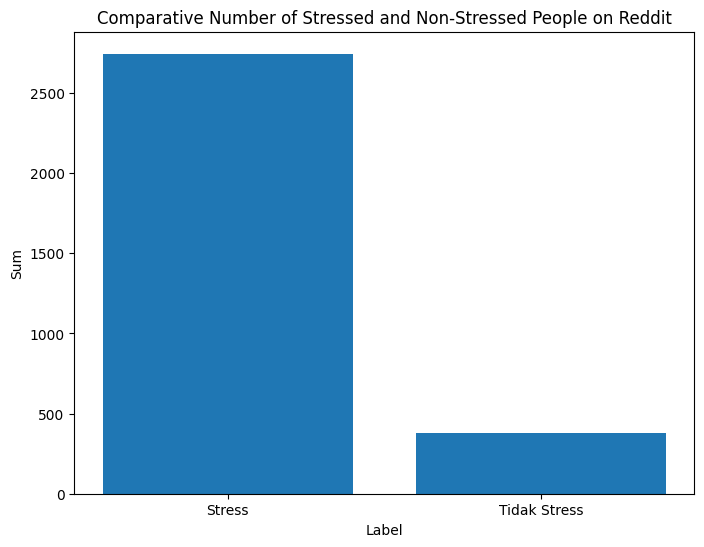

In [ ]:
plt.figure(figsize=(8, 6))
plt.bar(label_name, label_counts.values)
plt.xlabel('Label')
plt.ylabel('Sum')
plt.title('Comparative Number of Stressed and Non-Stressed People on Reddit')
plt.show()

Berdasarkan hasil visualisasi barchart pada dataset reddit, dapat dilihat bahwa komentar pada platform reddit didominasi oleh komentar dengan label stress. Visualisasi tersebut juga menunjukkan bahwa dataset reddit memiliki kesenjangan label yang signifikan. Oleh karena itu, dataset ini harus mengalami undersamping ataupun oversampling untuk meningkatkan performa model dalam proses pelatihan agar model dapat belajar lebih banyak mengenai komentar dengan label tidak stress.

### Histogram Visualization of Reddit Combi Data

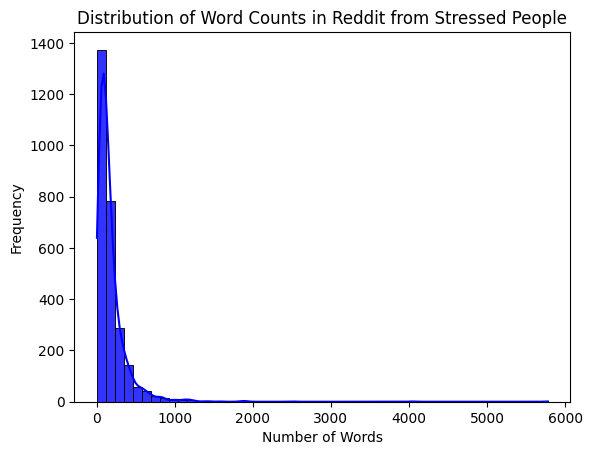

In [ ]:
teks_stress_reddit = reddit[reddit['label'] == 1]['Body_Title']
teks_stress_reddit = pd.DataFrame({'Body_Title': teks_stress_reddit})
teks_stress_reddit['text_length'] = teks_stress_reddit['Body_Title'].apply(lambda x: len(x.split()))
sns.histplot(teks_stress_reddit['text_length'], bins=50, color='blue', kde=True, alpha=0.8)
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts in Reddit from Stressed People')
plt.show()


Berdasarkan hasil visualisasi histogram pada dataset reddit, dapat dilihat bahwa frekuensi komentar dengan label stress tertinggi ada pada komentar yang memiliki kurang lebih 0 - 500 kata.

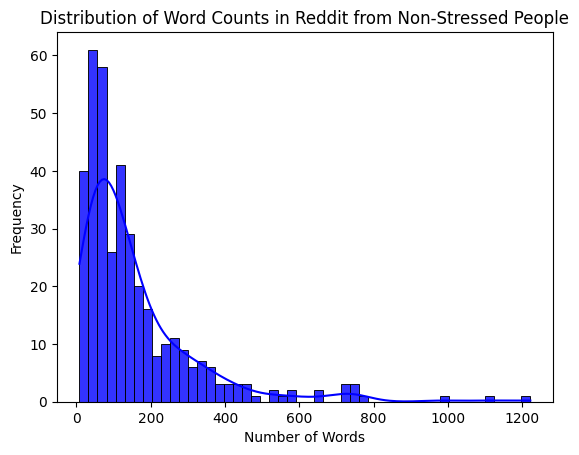

In [ ]:
teks_stress_no_reddit = reddit[reddit['label'] == 0]['Body_Title']
teks_stress_no_reddit = pd.DataFrame({'Body_Title': teks_stress_no_reddit})
teks_stress_no_reddit['text_length'] = teks_stress_no_reddit['Body_Title'].apply(lambda x: len(x.split()))
sns.histplot(teks_stress_no_reddit['text_length'], bins=50, color='blue', alpha=0.8, kde = True)
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts in Reddit from Non-Stressed People')
plt.show()


Berdasarkan hasil visualisasi histogram pada dataset reddit, dapat dilihat bahwa frekuensi komentar dengan label tidak stress tertinggi ada pada komentar yang memiliki kurang lebih 0 - 200 kata.

### Word Cloud of Reddit Combi Data

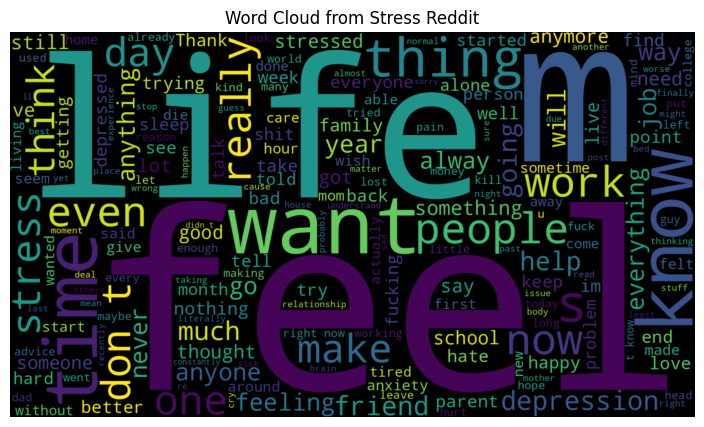

In [ ]:
all_text_stress_redd = ' '.join(reddit[reddit['label'] == 1]['Body_Title'])
wordcloud_stress_redd = WordCloud(
    background_color = 'black',
    height = 1080,
    width = 1920,
    stopwords = stopWords
)

wordcloud_stress_redd.generate(all_text_stress_redd)
# Display the WordCloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_stress_redd, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud from Stress Reddit')
plt.show()

Berdasarkan hasil visualisasi wordcloud pada dataset reddit, dapat dilihat bahwa kata yang banyak digunakan pada komentar dengan label stress adalah kata stress, stressed, dan depression.

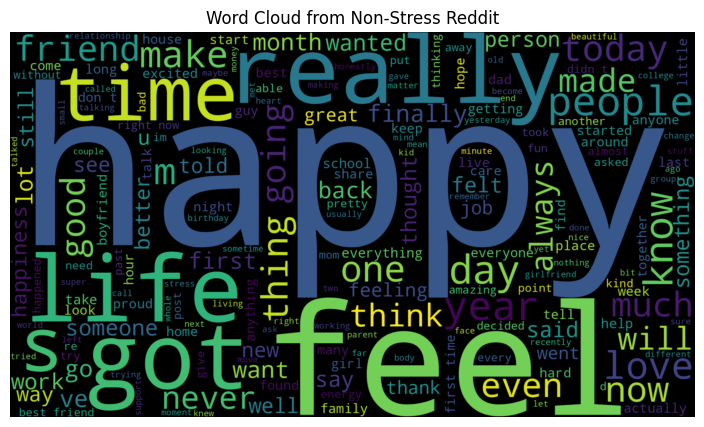

In [ ]:
all_text_no_stress_redd = ' '.join(reddit[reddit['label'] == 0]['Body_Title'])
wordcloud_no_stress_redd = WordCloud(
    background_color = 'black',
    height = 1080,
    width = 1920,
    stopwords = stopWords
)

wordcloud_no_stress_redd.generate(all_text_no_stress_redd)
# Display the WordCloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_no_stress_redd, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud from Non-Stress Reddit')
plt.show()

Berdasarkan hasil visualisasi wordcloud pada dataset reddit, dapat dilihat bahwa kata yang banyak digunakan pada komentar dengan label tidak stress adalah kata happy, happiness, dan great.

### Most Frequent Word in Reddit

In [ ]:
words_stress_reddit = all_text_stress_redd.split()
filter_word_stress_reddit = [word for word in words_stress_reddit if word.lower() not in stopWords]
words_stress_freq_reddit = Counter(filter_word_stress_reddit)
words_stress_freq_reddit = pd.DataFrame(list(words_stress_freq_reddit.items()), columns=['Word', 'Frequency'])
words_stress_freq_reddit = words_stress_freq_reddit.sort_values(by='Frequency', ascending=False)

In [ ]:
words_stress_freq_reddit

Word  Frequency
454         feel       2857
128          I’m       2092
36          want       1859
149         know       1786
147         even       1452
...          ...        ...
15402      each,          1
15403      job's          1
15406    safety,          1
15408      (0.1%          1
28698  visually.          1

[28699 rows x 2 columns]

In [ ]:
words_no_stress_redd = all_text_no_stress_redd.split()
filter_word_no_stress_redd = [word for word in words_no_stress_redd if word.lower() not in stopWords]
filter_word_no_stress_redd = Counter(filter_word_no_stress_redd)
word_no_stress_freq_redd_df = pd.DataFrame(list(filter_word_no_stress_redd.items()), columns=['Word', 'Frequency'])
word_no_stress_freq_redd_df = word_no_stress_freq_redd_df.sort_values(by='Frequency', ascending=False)

In [ ]:
word_no_stress_freq_redd_df

Word  Frequency
234        really        192
17           feel        185
184           got        180
42           know        170
1           happy        163
...           ...        ...
4126      Martens          1
4125          Doc          1
4123  ever...that          1
4122  **fishing**          1
8419    cackling.          1

[8420 rows x 2 columns]

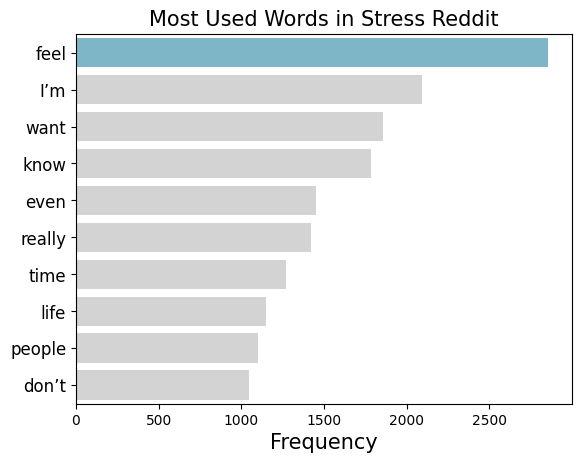

In [ ]:
colors = ["#72BCD4", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3"]
sns.barplot(x="Frequency", y="Word", data=words_stress_freq_reddit.head(10), palette=colors)
plt.ylabel(None)
plt.xlabel("Frequency", fontsize=15)
plt.title("Most Used Words in Stress Reddit", fontsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.show()

Berdasarkan hasil visualisasi most used word pada dataset reddit, dapat dilihat bahwa kata yang paling banyak digunakan pada komentar dengan label stress adalah kata feel.

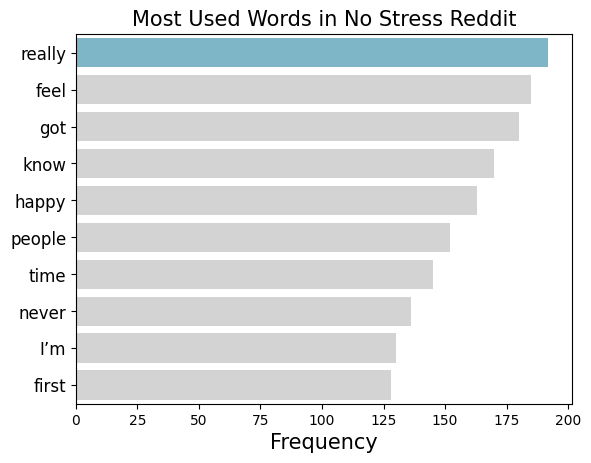

In [ ]:
colors = ["#72BCD4", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3"]
sns.barplot(x="Frequency", y="Word", data=word_no_stress_freq_redd_df.head(10), palette=colors)
plt.ylabel(None)
plt.xlabel("Frequency", fontsize=15)
plt.title("Most Used Words in No Stress Reddit", fontsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.show()

Berdasarkan hasil visualisasi most used word pada dataset reddit, dapat dilihat bahwa kata yang paling banyak digunakan pada komentar dengan label tidak stress adalah kata really.

# **Data Preparation**

## Clean Text

In [ ]:
# CUSTOM DEFINED FUNCTIONS TO CLEAN THE DATA

# Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text):
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

# Clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

# Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

# Remove multiple spaces
def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)

## BERT TOKENIZER

In [ ]:
tokenizer_bert = BertTokenizerFast.from_pretrained('bert-base-uncased')

### Check Max Length Token

In [ ]:
def check_max_len_bert(data):
    token_lens = []
    for txt in data:
        tokens = tokenizer_bert.encode(txt, max_length=100000, truncation=True)
        token_lens.append(len(tokens))
    return np.max(token_lens)

### Filter The Token Twitter

In [ ]:
# Filter function
def filter_token_data_twitter_bert(data, maxlen):
    data_to_dataframe = []
    token_lens_test = []
    for i, txt in enumerate(data):
        tokens = tokenizer_bert.encode(txt, max_length=maxlen, truncation=True)
        token_lens_test.append(len(tokens))
        if len(tokens) < 256:
            matching_data = twitter[twitter['text'] == txt]
            if not matching_data.empty:
                label = matching_data['label'].values[0]
                data_to_dataframe.append({"text": txt, "label": label} )

    return pd.DataFrame(data_to_dataframe)

### Filter The Token Reddit

In [ ]:
# Filter function
def filter_token_data_reddit_bert(data, maxlen):
    data_to_dataframe = []
    token_lens_test = []
    for i, txt in enumerate(data):
        tokens = tokenizer_bert.encode(txt, max_length=maxlen, truncation=True)
        token_lens_test.append(len(tokens))
        if len(tokens) < 256:
            matching_data = reddit[reddit['body_title'] == txt]
            if not matching_data.empty:
                label = matching_data['label'].values[0]
                data_to_dataframe.append({"body_title": txt, "label": label} )

    return pd.DataFrame(data_to_dataframe)

## ROBERTA TOKENIZER

In [ ]:
tokenizer_roberta = RobertaTokenizerFast.from_pretrained("roberta-base")

### Check Length of Roberta Tokenizer

In [ ]:
def check_max_len_roberta(data):
    token_lens = []
    for txt in data:
        tokens = tokenizer_roberta.encode(txt, max_length=100000, truncation=True)
        token_lens.append(len(tokens))
    return np.max(token_lens)

### Filter Token For Twitter

In [ ]:
# Filter function
def filter_token_data_twitter_roberta(data, maxlen):
    data_to_dataframe = []
    token_lens_test = []
    for i, txt in enumerate(data):
        tokens = tokenizer_roberta.encode(txt, max_length=maxlen, truncation=True)
        token_lens_test.append(len(tokens))
        if len(tokens) < 256:
            matching_data = twitter[twitter['text'] == txt]
            if not matching_data.empty:
                label = matching_data['label'].values[0]
                data_to_dataframe.append({"text": txt, "label": label} )

    return pd.DataFrame(data_to_dataframe)

### Filter Token For Reddit

In [ ]:
# Filter function
def filter_token_data_reddit_roberta(data, maxlen):
    data_to_dataframe = []
    token_lens_test = []
    for i, txt in enumerate(data):
        tokens = tokenizer_roberta.encode(txt, max_length=maxlen, truncation=True)
        token_lens_test.append(len(tokens))
        if len(tokens) < 256:
            matching_data = reddit[reddit['body_title'] == txt]
            if not matching_data.empty:
                label = matching_data['label'].values[0]
                data_to_dataframe.append({"body_title": txt, "label": label} )

    return pd.DataFrame(data_to_dataframe)

## Twitter

### Data Cleaning

In [ ]:
# Drop duplicate
twitter.drop_duplicates(inplace = True)
twitter.reset_index(drop = True, inplace=True)
print("Sum of Duplicated Data in Twitter No Adver ",twitter.duplicated().sum())

Sum of Duplicated Data in Twitter No Adver  0


In [ ]:
# Lower Case All dataframe
twitter['text'] = twitter['text'].apply(lambda x: x.lower())

In [ ]:
texts_new_twitter = []
for t in twitter['text']:
    texts_new_twitter.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(t)))))

In [ ]:
twitter['text'] = texts_new_twitter

In [ ]:
twitter.head(5)

text  label
0  speaknoevil monkey can i be honest with you gl...      1
1  frau goebbels early signs of psychosis psychot...      1
2  a lot of work and unfulfilled tasks plunge you...      1
3  private health insurance delivers value for yo...      1
4  xpertonline offers you the convenience of view...      1

In [ ]:
all_text_stress_twit = ' '.join(twitter[twitter['label']==1]['text'])

In [ ]:
all_text_no_stress_twit = ' '.join(twitter[twitter['label']==1]['text'])

In [ ]:
words_stress_twitt = all_text_stress_twit.split()
filter_word_stress_twitt = [word for word in words_stress_twitt if word.lower() not in stopWords]
words_stress_freq_twitt = Counter(filter_word_stress_twitt)
word_stress_freq_twitt_df = pd.DataFrame(list(words_stress_freq_twitt.items()), columns=['Word', 'Frequency'])
word_stress_freq_twitt_df = word_stress_freq_twitt_df.sort_values(by='Frequency', ascending=False)

In [ ]:
word_stress_freq_twitt_df

Word  Frequency
18                 stress        672
15           mentalhealth        567
52                 health        385
60                 mental        194
152   mentalhealthmatters        189
...                   ...        ...
3806    neurodegenerative          1
3807              concert          1
3808           epigenetic          1
3810              diverse          1
6762                 m1hl          1

[6763 rows x 2 columns]

In [ ]:
words_no_stress_twitt = all_text_no_stress_twit.split()
filter_word_no_stress_twitt = [word for word in words_no_stress_twitt if word.lower() not in stopWords]
filter_word_no_stress_twitt = Counter(filter_word_no_stress_twitt)
word_no_stress_freq_twitt_df = pd.DataFrame(list(filter_word_no_stress_twitt.items()), columns=['Word', 'Frequency'])
word_no_stress_freq_twitt_df = word_no_stress_freq_twitt_df.sort_values(by='Frequency', ascending=False)

In [ ]:
word_no_stress_freq_twitt_df

Word  Frequency
18                 stress        672
15           mentalhealth        567
52                 health        385
60                 mental        194
152   mentalhealthmatters        189
...                   ...        ...
3806    neurodegenerative          1
3807              concert          1
3808           epigenetic          1
3810              diverse          1
6762                 m1hl          1

[6763 rows x 2 columns]

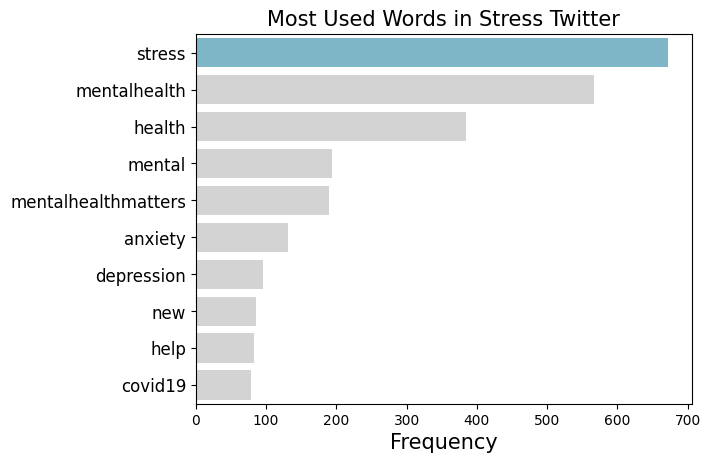

In [ ]:
colors = ["#72BCD4", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3"]
sns.barplot(x="Frequency", y="Word", data=word_stress_freq_twitt_df.head(10), palette=colors)
plt.ylabel(None)
plt.xlabel("Frequency", fontsize=15)
plt.title("Most Used Words in Stress Twitter", fontsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.show()

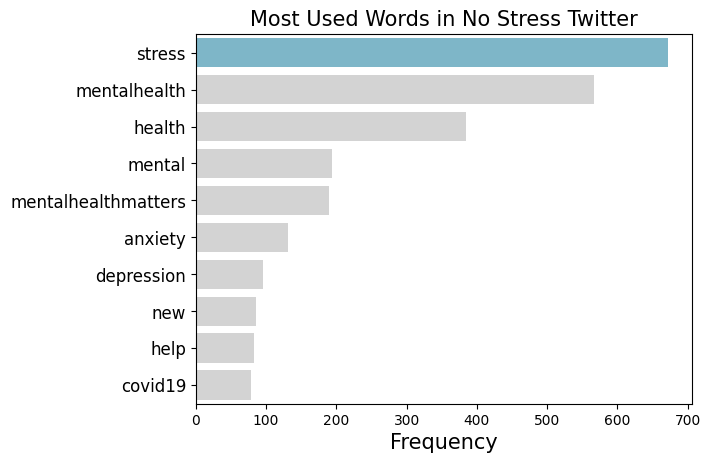

In [ ]:
colors = ["#72BCD4", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3"]
sns.barplot(x="Frequency", y="Word", data=word_no_stress_freq_twitt_df.head(10), palette=colors)
plt.ylabel(None)
plt.xlabel("Frequency", fontsize=15)
plt.title("Most Used Words in No Stress Twitter", fontsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.show()

### BERT Tokenizer Filter for Twitter

In [ ]:
train_x_twitter_bert = twitter['text']
train_y_twitter_bert = twitter['label']

In [ ]:
max_len_twitter_bert = check_max_len_bert(train_x_twitter_bert)
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len_twitter_bert}")

MAX TOKENIZED SENTENCE LENGTH: 83


In [ ]:
twitter_model_bert = filter_token_data_twitter_bert(train_x_twitter_bert, max_len_twitter_bert)
twitter_model_bert.reset_index(drop = True, inplace=True)
print(twitter_model_bert)

                                                   text  label
0     speaknoevil monkey can i be honest with you gl...      1
1     frau goebbels early signs of psychosis psychot...      1
2     a lot of work and unfulfilled tasks plunge you...      1
3     private health insurance delivers value for yo...      1
4     xpertonline offers you the convenience of view...      1
...                                                 ...    ...
1967  cbcalerts being part of the war criminal organ...      1
1968  therapy is not only for those who have receive...      1
1969  stanford study being kind to others improves b...      1
1970  no mobile phones three tips to reduce technost...      1
1971  police car light new product alert police car ...      0

[1972 rows x 2 columns]


In [ ]:
label_counts_twitter = twitter_model_bert['label'].value_counts()
label_counts_twitter

1    1212
0     760
Name: label, dtype: int64

### EDA BERT After Data-Preprocessing

#### Bar-Chart Visualization of Twitter-No-Adver Data

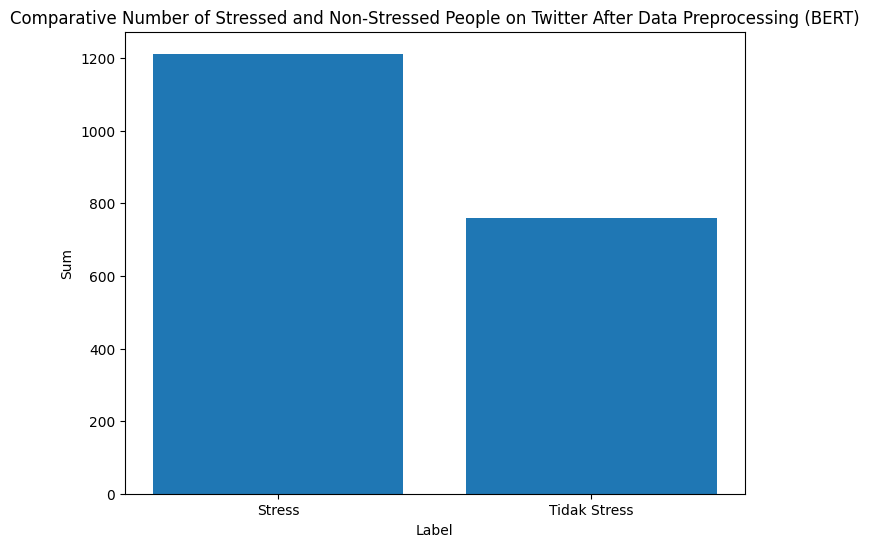

In [ ]:
plt.figure(figsize=(8, 6))
plt.bar(label_name, label_counts_twitter.values)
plt.xlabel('Label')
plt.ylabel('Sum')
plt.title('Comparative Number of Stressed and Non-Stressed People on Twitter After Data Preprocessing (BERT)')
plt.show()

#### Histogram Visualization of Twitter-No-Adver Data

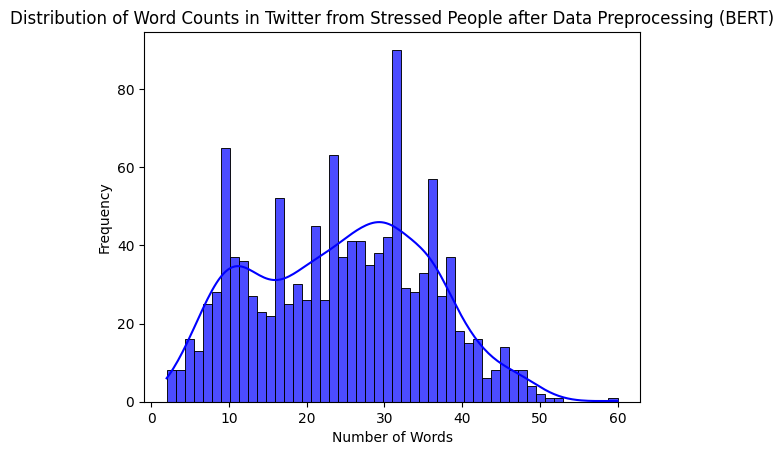

In [ ]:
teks_stress_twitter_bert = twitter_model_bert[twitter_model_bert['label'] == 1]['text']
teks_stress_twitter_bert = pd.DataFrame({'text': teks_stress_twitter_bert})
teks_stress_twitter_bert['text_length'] = teks_stress_twitter_bert['text'].apply(lambda x: len(x.split()))
sns.histplot(teks_stress_twitter_bert['text_length'], bins=50, color='blue', kde = True,alpha=0.7)
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts in Twitter from Stressed People after Data Preprocessing (BERT)')
plt.show()

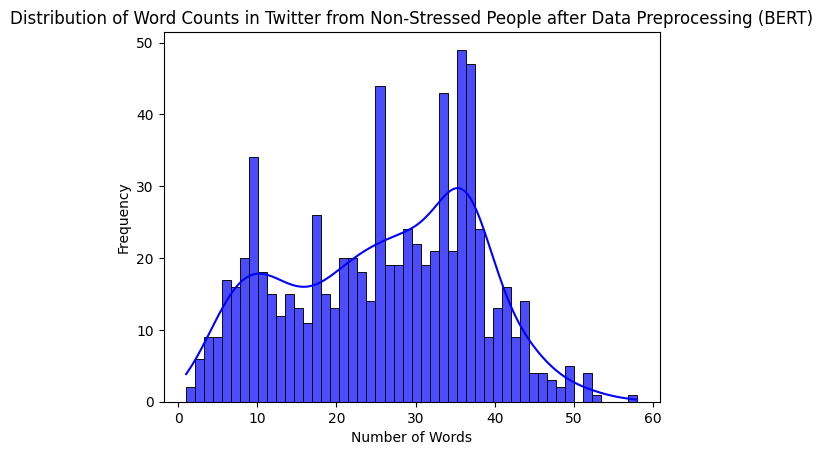

In [ ]:
teks_stress_no_twitter_bert = twitter_model_bert[twitter_model_bert['label'] == 0]['text']
teks_stress_no_twitter_bert = pd.DataFrame({'text': teks_stress_no_twitter_bert})
teks_stress_no_twitter_bert['text_length'] = teks_stress_no_twitter_bert['text'].apply(lambda x: len(x.split()))
sns.histplot(teks_stress_no_twitter_bert['text_length'], bins=50, color='blue', kde = True,alpha=0.7)
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts in Twitter from Non-Stressed People after Data Preprocessing (BERT)')
plt.show()

#### Word Cloud of Twitter-No-Adver Data

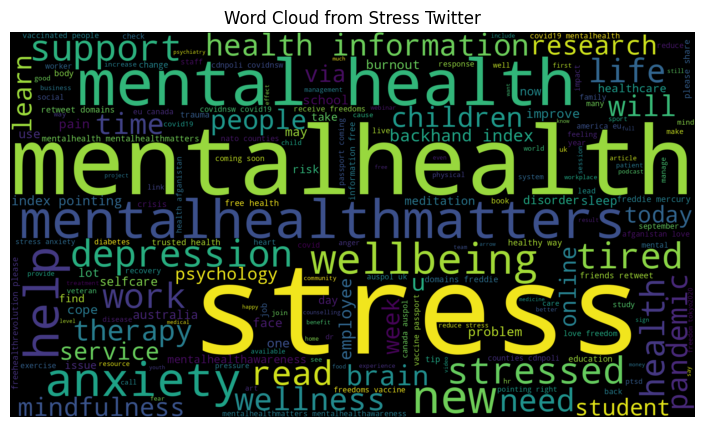

In [ ]:
twitt_prec_stress_bert = ' '.join(twitter_model_bert[twitter_model_bert['label'] == 1]['text'])
wordcloud_prec_stress_bert = WordCloud(
    background_color = 'black',
    height = 1080,
    width = 1920,
    stopwords = stopWords
)
wordcloud_prec_stress_bert.generate(twitt_prec_stress_bert)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_prec_stress_bert, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud from Stress Twitter')
plt.show()

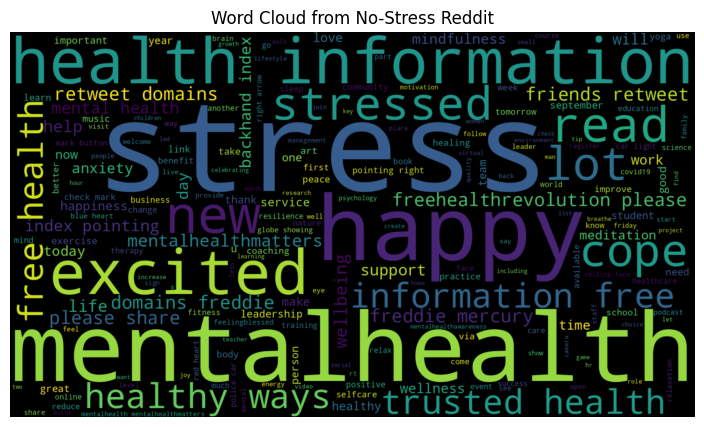

In [ ]:
twitt_prec_no_stress_bert = ' '.join(twitter_model_bert[twitter_model_bert['label'] == 0]['text'])
wordcloud_prec_no_stress_bert = WordCloud(
    background_color = 'black',
    height = 1080,
    width = 1920,
    stopwords = stopWords
)
wordcloud_prec_no_stress_bert.generate(twitt_prec_no_stress_bert)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_prec_no_stress_bert, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud from No-Stress Reddit')
plt.show()

### Convert into Excel

In [ ]:
folder_path = '/content/output'
excel_file_name = 'twitter_model_bert.xlsx'

In [ ]:
import os

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

In [ ]:
excel_file_path = os.path.join(folder_path, excel_file_name)

In [ ]:
twitter_model_bert.to_excel(excel_file_path, index=False)

### Train Test Split BERT For Twitter-Non-Adver

In [ ]:
train_x_twitter_bert_model = twitter_model_bert['text'].values
train_y_twitter_bert_model = twitter_model_bert['label'].values

In [ ]:
train_twit_x_bert,test_twit_x_bert,train_twit_y_bert,test_twit_y_bert = train_test_split(train_x_twitter_bert_model,train_y_twitter_bert_model, test_size = .4,stratify = train_y_twitter_bert_model, shuffle = True, random_state = 41)

In [ ]:
val_twit_x_bert, test_twit_x_bert, val_twit_y_bert, test_twit_y_bert = train_test_split(test_twit_x_bert, test_twit_y_bert, test_size=0.5,stratify = test_twit_y_bert, shuffle=True, random_state=42)

In [ ]:
ohe = preprocessing.OneHotEncoder()

train_twit_y_bert = ohe.fit_transform(np.array(train_twit_y_bert).reshape(-1, 1)).toarray()
val_twit_y_bert = ohe.fit_transform(np.array(val_twit_y_bert).reshape(-1, 1)).toarray()
test_twit_y_bert = ohe.fit_transform(np.array(test_twit_y_bert).reshape(-1, 1)).toarray()

### ROBERTA Tokenizer Filter for Twitter

In [ ]:
train_x_twitter_roberta = twitter['text']
train_y_twitter_roberta = twitter['label']

In [ ]:
max_len_twitter_roberta = check_max_len_roberta(train_x_twitter_roberta)
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len_twitter_roberta}")

MAX TOKENIZED SENTENCE LENGTH: 86


In [ ]:
twitter_model_roberta = filter_token_data_twitter_roberta(train_x_twitter_roberta, max_len_twitter_roberta)
twitter_model_roberta.reset_index(drop = True, inplace=True)
print(twitter_model_roberta)

                                                   text  label
0     speaknoevil monkey can i be honest with you gl...      1
1     frau goebbels early signs of psychosis psychot...      1
2     a lot of work and unfulfilled tasks plunge you...      1
3     private health insurance delivers value for yo...      1
4     xpertonline offers you the convenience of view...      1
...                                                 ...    ...
1967  cbcalerts being part of the war criminal organ...      1
1968  therapy is not only for those who have receive...      1
1969  stanford study being kind to others improves b...      1
1970  no mobile phones three tips to reduce technost...      1
1971  police car light new product alert police car ...      0

[1972 rows x 2 columns]


In [ ]:
label_counts_twitter = twitter_model_roberta['label'].value_counts()
label_counts_twitter

1    1212
0     760
Name: label, dtype: int64

### EDA After Data-Preprocessing

#### Bar-Chart Visualisation of Twitter-No-Adver Data

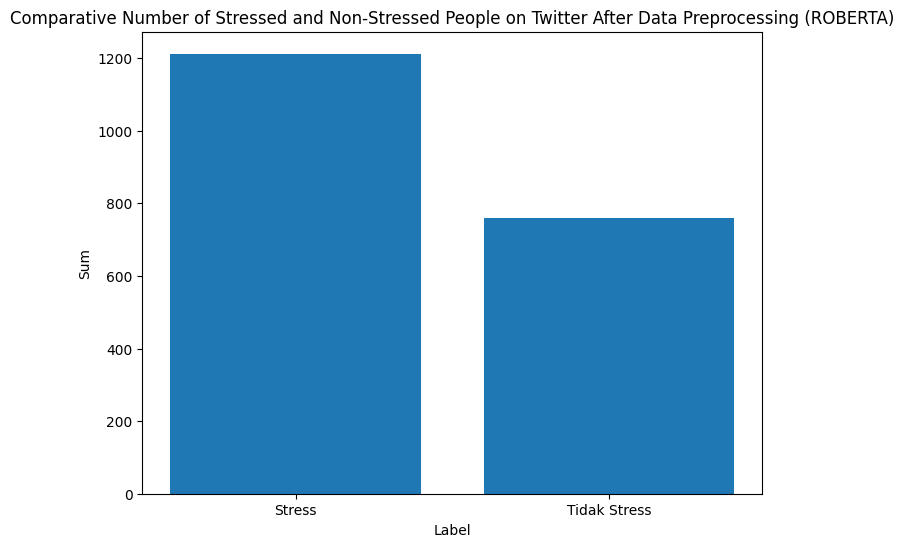

In [ ]:
plt.figure(figsize=(8, 6))
plt.bar(label_name, label_counts_twitter.values)
plt.xlabel('Label')
plt.ylabel('Sum')
plt.title('Comparative Number of Stressed and Non-Stressed People on Twitter After Data Preprocessing (ROBERTA)')
plt.show()

#### Histogram Visualization of Twitter-No-Adver Data

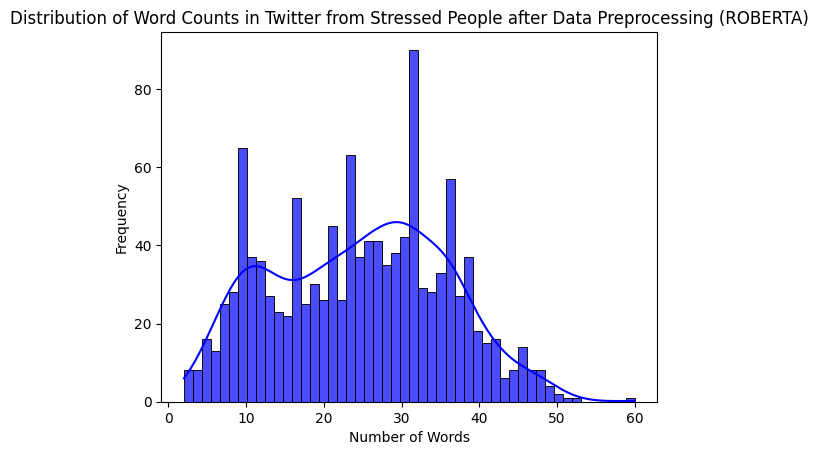

In [ ]:
teks_stress_twitter_roberta = twitter_model_roberta[twitter_model_bert['label'] == 1]['text']
teks_stress_twitter_roberta = pd.DataFrame({'text': teks_stress_twitter_roberta})
teks_stress_twitter_roberta['text_length'] = teks_stress_twitter_roberta['text'].apply(lambda x: len(x.split()))
sns.histplot(teks_stress_twitter_roberta['text_length'], bins=50, color='blue', kde = True,alpha=0.7)
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts in Twitter from Stressed People after Data Preprocessing (ROBERTA)')
plt.show()

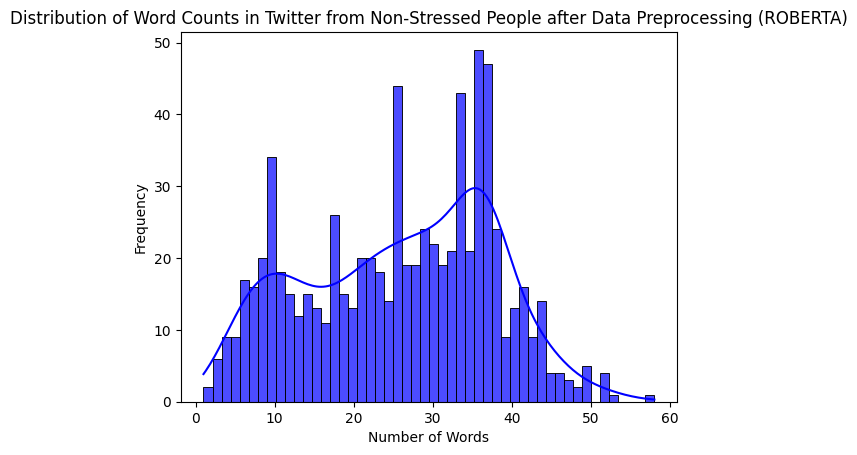

In [ ]:
teks_stress_no_twitter_roberta = twitter_model_roberta[twitter_model_bert['label'] == 0]['text']
teks_stress_no_twitter_roberta = pd.DataFrame({'text': teks_stress_no_twitter_roberta})
teks_stress_no_twitter_roberta['text_length'] = teks_stress_no_twitter_roberta['text'].apply(lambda x: len(x.split()))
sns.histplot(teks_stress_no_twitter_roberta['text_length'], bins=50, color='blue', alpha=0.7, kde = True)
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts in Twitter from Non-Stressed People after Data Preprocessing (ROBERTA)')
plt.show()

#### Word Cloud of Twitter-No-Adver Data

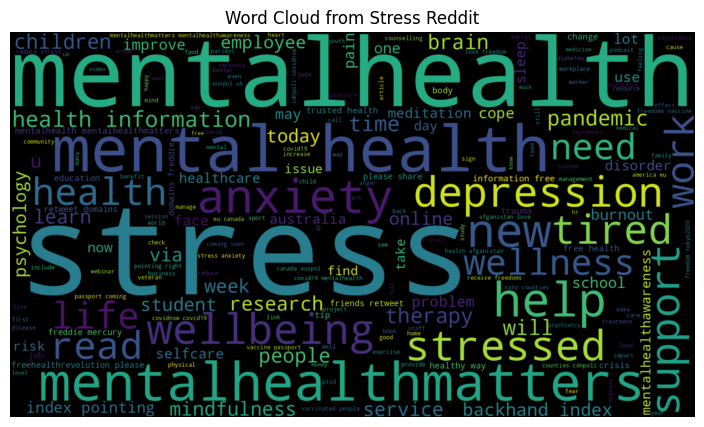

In [ ]:
twitt_prec_stress_roberta = ' '.join(twitter_model_roberta[twitter_model_bert['label'] == 1]['text'])
wordcloud_prec_stress_roberta = WordCloud(
    background_color = 'black',
    height = 1080,
    width = 1920,
    stopwords = stopWords
)
wordcloud_prec_stress_roberta.generate(twitt_prec_stress_roberta)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_prec_stress_roberta, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud from Stress Reddit')
plt.show()

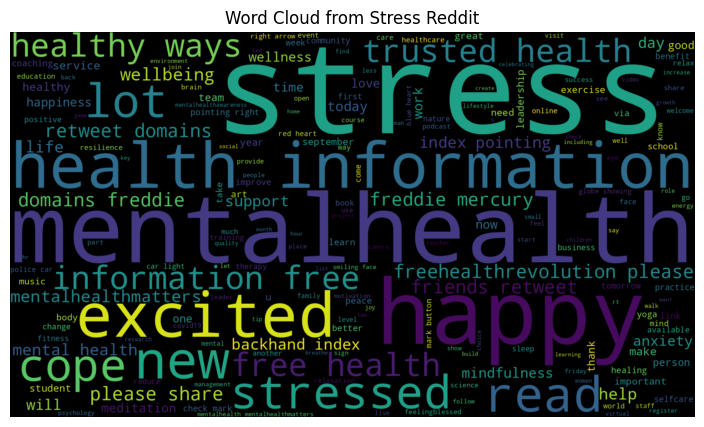

In [ ]:
twitt_prec_no_stress_roberta = ' '.join(twitter_model_roberta[twitter_model_bert['label'] == 0]['text'])
wordcloud_prec_stress_roberta = WordCloud(
    background_color = 'black',
    height = 1080,
    width = 1920,
    stopwords = stopWords
)
wordcloud_prec_stress_roberta.generate(twitt_prec_no_stress_roberta)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_prec_stress_roberta, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud from Stress Reddit')
plt.show()

### Convert To Excel

In [ ]:
folder_path = '/content/output'
excel_file_name = 'twitter_model_roberta.xlsx'

In [ ]:
import os

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

In [ ]:
excel_file_path = os.path.join(folder_path, excel_file_name)

In [ ]:
twitter_model_bert.to_excel(excel_file_path, index=False)

### Train Test Split Roberta

In [ ]:
train_x_twitter_roberta_model = twitter_model_roberta['text'].values
train_y_twitter_roberta_model = twitter_model_roberta['label'].values

In [ ]:
train_twit_x_roberta,test_twit_x_roberta,train_twit_y_roberta,test_twit_y_roberta = train_test_split(train_x_twitter_roberta_model,train_y_twitter_roberta_model, test_size = .4,stratify = train_y_twitter_roberta_model, shuffle = True, random_state = 41)

In [ ]:
val_twit_x_roberta, test_twit_x_roberta, val_twit_y_roberta, test_twit_y_roberta = train_test_split(test_twit_x_roberta, test_twit_y_roberta, test_size=0.5,stratify = test_twit_y_roberta, shuffle=True, random_state=42)

In [ ]:
ohe = preprocessing.OneHotEncoder()

train_twit_y_roberta = ohe.fit_transform(np.array(train_twit_y_roberta).reshape(-1, 1)).toarray()
val_twit_y_roberta = ohe.fit_transform(np.array(val_twit_y_roberta).reshape(-1, 1)).toarray()
test_twit_y_roberta = ohe.fit_transform(np.array(test_twit_y_roberta).reshape(-1, 1)).toarray()

## Reddit

### Data Cleaning

In [ ]:
reddit.dropna(axis = 0,inplace = True)
reddit.reset_index(drop = True, inplace=True)

In [ ]:
# Check Na and Null in Reddit Combi
print("Sum of Missing Value in Reddit Combi",reddit.value_counts().isna().sum())

Sum of Missing Value in Reddit Combi 0


### Reconstruction of Body Titles in Reddit Combi

In [ ]:
columns_to_drop = ['Body_Title']
reddit.drop(columns=columns_to_drop, inplace=True)

In [ ]:
reddit['body_title'] = reddit['title'] + " " + reddit['body']
new_column_order = ['title', 'body', 'body_title', 'label']

reddit = reddit[new_column_order]
reddit.head(5)

title  \
0                     Envy to other is swallowing me   
1  Nothin outta the ordinary. Paradise. Job stres...   
2  Almost 49 and the chasm of emptiness has never...   
3                                    I’m happy again   
4  Is it possible to recover from such a traumati...   

                                                body  \
0  Im from developingcountry, Indonesia , and for...   
1  Um hello ....well many can relate im sure. Aft...   
2  I’ve been diagnosed severe bi polar where you ...   
3  After my closest friend left me in April, I ha...   
4  I am only 15, and yet I feel my life is alread...   

                                          body_title  label  
0  Envy to other is swallowing me Im from develop...      1  
1  Nothin outta the ordinary. Paradise. Job stres...      1  
2  Almost 49 and the chasm of emptiness has never...      1  
3  I’m happy again After my closest friend left m...      0  
4  Is it possible to recover from such a traumati...      1

In [ ]:
# Lower Case All dataframe
reddit['body_title'] = reddit['body_title'].apply(lambda x: x.lower())

In [ ]:
texts_new_reddit = []
for t in reddit['body_title']:
    texts_new_reddit.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(t)))))

In [ ]:
reddit['body_title'] = texts_new_reddit

In [ ]:
reddit.head(5)

title  \
0                     Envy to other is swallowing me   
1  Nothin outta the ordinary. Paradise. Job stres...   
2  Almost 49 and the chasm of emptiness has never...   
3                                    I’m happy again   
4  Is it possible to recover from such a traumati...   

                                                body  \
0  Im from developingcountry, Indonesia , and for...   
1  Um hello ....well many can relate im sure. Aft...   
2  I’ve been diagnosed severe bi polar where you ...   
3  After my closest friend left me in April, I ha...   
4  I am only 15, and yet I feel my life is alread...   

                                          body_title  label  
0  envy to other is swallowing me im from develop...      1  
1  nothin outta the ordinary paradise job stress ...      1  
2  almost 49 and the chasm of emptiness has never...      1  
3  im happy again after my closest friend left me...      0  
4  is it possible to recover from such a traumati...      1

In [ ]:
all_text_stress_redd = ' '.join(reddit[reddit['label'] == 1]['body_title'])

In [ ]:
all_text_no_stress_redd = ' '.join(reddit[reddit['label'] == 0]['body_title'])

In [ ]:
words_stress_reddit = all_text_stress_redd.split()
filter_word_stress_reddit = [word for word in words_stress_reddit if word.lower() not in stopWords]
words_stress_freq_reddit = Counter(filter_word_stress_reddit)
words_stress_freq_reddit = pd.DataFrame(list(words_stress_freq_reddit.items()), columns=['Word', 'Frequency'])
words_stress_freq_reddit = words_stress_freq_reddit.sort_values(by='Frequency', ascending=False)

In [ ]:
words_stress_freq_reddit

Word  Frequency
2              im       5807
167          dont       3160
367          feel       2921
124          know       1909
30           want       1902
...           ...        ...
8822      nowlate          1
8820   unfriendly          1
8817     outlined          1
8815        profs          1
14648   charaters          1

[14649 rows x 2 columns]

In [ ]:
words_no_stress_redd = all_text_no_stress_redd.split()
filter_word_no_stress_redd = [word for word in words_no_stress_redd if word.lower() not in stopWords]
filter_word_no_stress_redd = Counter(filter_word_no_stress_redd)
word_no_stress_freq_redd_df = pd.DataFrame(list(filter_word_no_stress_redd.items()), columns=['Word', 'Frequency'])
word_no_stress_freq_redd_df = word_no_stress_freq_redd_df.sort_values(by='Frequency', ascending=False)

In [ ]:
word_no_stress_freq_redd_df

Word  Frequency
0           im        439
1        happy        250
15        time        215
150        ive        213
13        life        201
...        ...        ...
2956    report          1
2959    desire          1
2960     clues          1
2961    tweets          1
5329  cackling          1

[5330 rows x 2 columns]

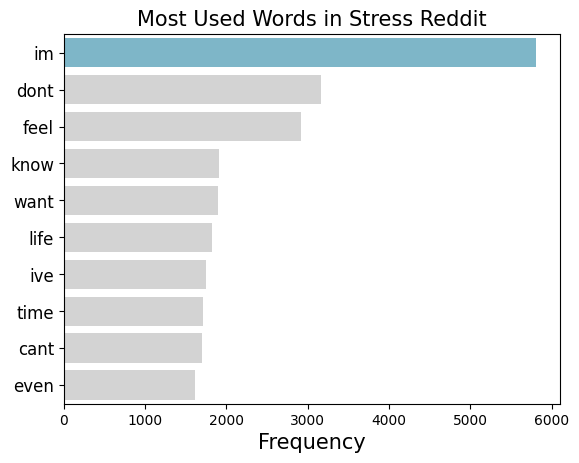

In [ ]:
colors = ["#72BCD4", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3"]
sns.barplot(x="Frequency", y="Word", data=words_stress_freq_reddit.head(10), palette=colors)
plt.ylabel(None)
plt.xlabel("Frequency", fontsize=15)
plt.title("Most Used Words in Stress Reddit", fontsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.show()

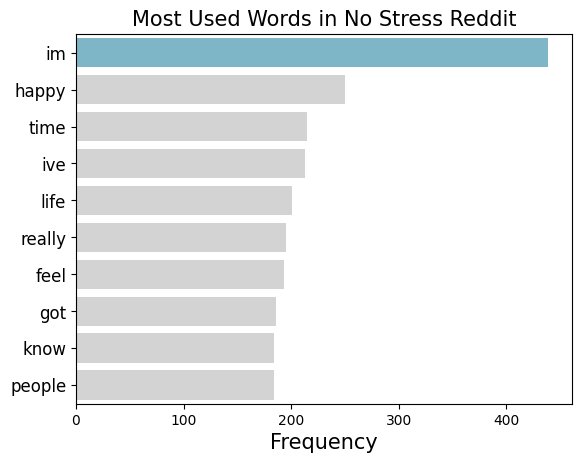

In [ ]:
colors = ["#72BCD4", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3", "#D3D3D3"]
sns.barplot(x="Frequency", y="Word", data=word_no_stress_freq_redd_df.head(10), palette=colors)
plt.ylabel(None)
plt.xlabel("Frequency", fontsize=15)
plt.title("Most Used Words in No Stress Reddit", fontsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.show()

## BERT

### BERT Tokenizer Filter for Reddit Combi

In [ ]:
train_x_reddit_bert  = reddit['body_title']
train_y_reddit_bert  = reddit['label']

In [ ]:
max_len_reddit_bert  = check_max_len_bert (train_x_reddit_bert )
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len_reddit_bert }")

MAX TOKENIZED SENTENCE LENGTH: 6015


In [ ]:
reddit_model_bert  = filter_token_data_reddit_bert(train_x_reddit_bert , max_len_reddit_bert )
reddit_model_bert .reset_index(drop = True, inplace=True)
print(reddit_model_bert )

                                             body_title  label
0     envy to other is swallowing me im from develop...      1
1     almost 49 and the chasm of emptiness has never...      1
2     im happy again after my closest friend left me...      0
3     im finding it hard to find a reason to get up ...      1
4     i convinced myself i was going to commit suici...      1
...                                                 ...    ...
2466  positive relief ideas with stress hi all my mo...      1
2467  breakdown i really think i lost my mind last n...      1
2468  i feel as if i actually died a long time ago a...      1
2469  is it wierd that i have imaginary friends at t...      1
2470  head and eye pressure since october for the la...      1

[2471 rows x 2 columns]


### Original Data Reddit Combi Based on BERT Tokenizer

In [ ]:
reddit_model_bert_ori = reddit_model_bert

In [ ]:
label_counts_ori_reddit = reddit_model_bert_ori['label'].value_counts()
label_counts_ori_reddit

1    2168
0     303
Name: label, dtype: int64

### UnderSampling Data Reddit Combi Based On BERT Tokenizer

In [ ]:
from sklearn.utils import resample

majority_class = reddit_model_bert [reddit_model_bert ['label'] == 1]
minority_class = reddit_model_bert [reddit_model_bert ['label'] == 0]

undersampled_majority = resample(majority_class,
                                 replace=False,
                                 n_samples=len(minority_class) * 2,
                                 random_state=42)

reddit_model_final_bert_undersap = pd.concat([minority_class, undersampled_majority])

In [ ]:
reddit_model_final_bert_undersap  = reddit_model_final_bert_undersap.sample(frac=1).reset_index(drop=True)

In [ ]:
label_counts_2 = reddit_model_final_bert_undersap ['label'].value_counts()
label_counts_2

1    606
0    303
Name: label, dtype: int64

### EDA BERT After Data-Preprocessing

#### Bar-Chart Visualization of Reddit-Combi Data

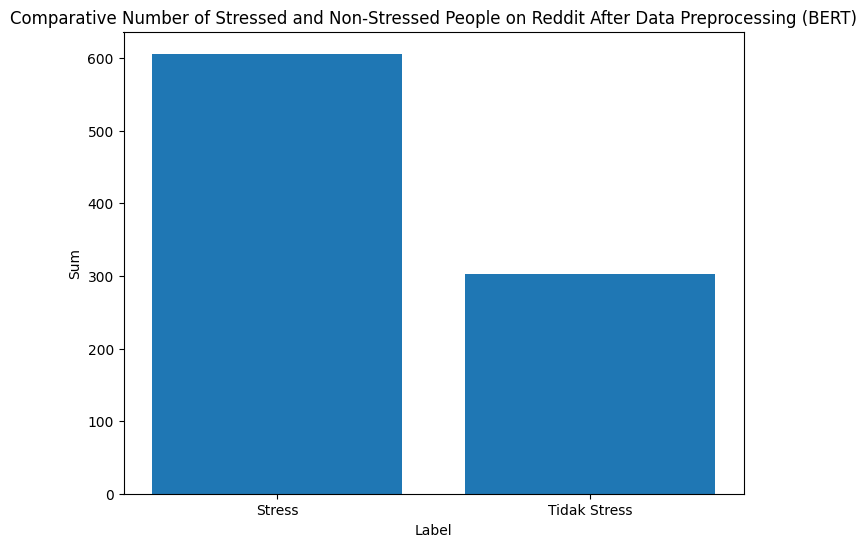

In [ ]:
plt.figure(figsize=(8, 6))
plt.bar(label_name, label_counts_2.values)
plt.xlabel('Label')
plt.ylabel('Sum')
plt.title('Comparative Number of Stressed and Non-Stressed People on Reddit After Data Preprocessing (BERT)')
plt.show()

#### Histogram Visualization of Reddit Combi Data

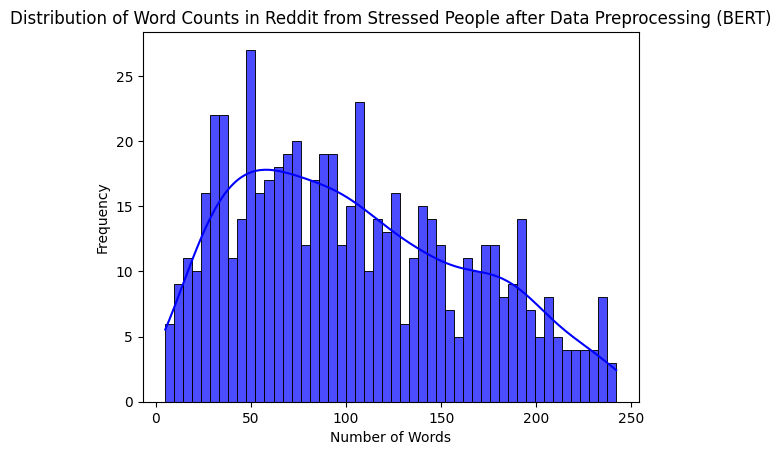

In [ ]:
teks_stress_reddit_bert = reddit_model_final_bert_undersap[reddit_model_final_bert_undersap['label'] == 1]['body_title']
teks_stress_reddit_bert = pd.DataFrame({'body_title': teks_stress_reddit_bert})
teks_stress_reddit_bert['text_length'] = teks_stress_reddit_bert['body_title'].apply(lambda x: len(x.split()))
sns.histplot(teks_stress_reddit_bert['text_length'], bins=50, color='blue', kde = True,alpha=0.7)
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts in Reddit from Stressed People after Data Preprocessing (BERT)')
plt.show()


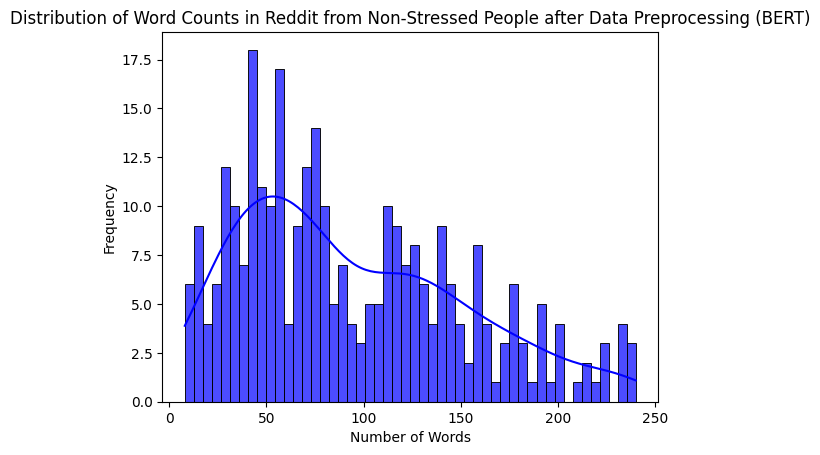

In [ ]:
teks_stress_no_reddit_bert = reddit_model_final_bert_undersap[reddit_model_final_bert_undersap['label'] == 0]['body_title']
teks_stress_no_reddit_bert = pd.DataFrame({'body_title': teks_stress_no_reddit_bert})
teks_stress_no_reddit_bert['text_length'] = teks_stress_no_reddit_bert['body_title'].apply(lambda x: len(x.split()))
sns.histplot(teks_stress_no_reddit_bert['text_length'], bins=50, color='blue',kde = True, alpha=0.7)
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts in Reddit from Non-Stressed People after Data Preprocessing (BERT)')
plt.show()


#### Word Cloud of Reddit Combi Data

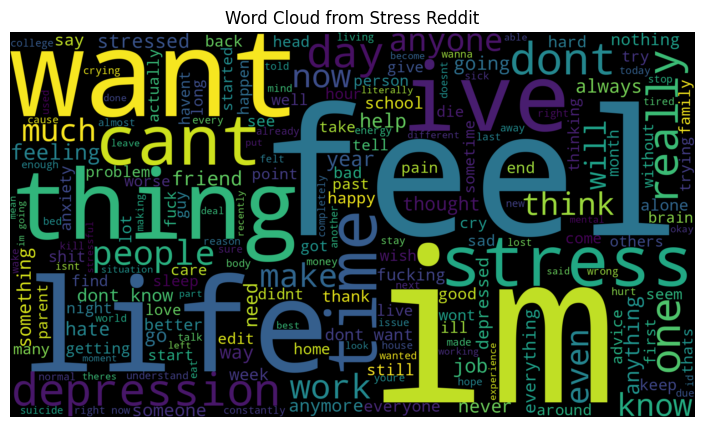

In [ ]:
reddit_prec_stress_bert = ' '.join(reddit_model_final_bert_undersap[reddit_model_final_bert_undersap['label'] == 1]['body_title'])
wordcloud_prec_stress_bert = WordCloud(
    background_color = 'black',
    height = 1080,
    width = 1920,
    stopwords = stopWords
)
wordcloud_prec_stress_bert.generate(reddit_prec_stress_bert)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_prec_stress_bert, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud from Stress Reddit')
plt.show()

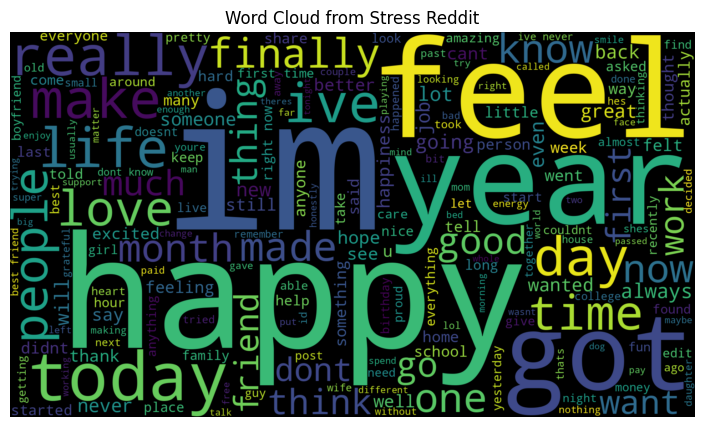

In [ ]:
reddit_no_prec_stress_bert = ' '.join(reddit_model_final_bert_undersap[reddit_model_final_bert_undersap['label'] == 0]['body_title'])
wordcloud_no_prec_stress_bert = WordCloud(
    background_color = 'black',
    height = 1080,
    width = 1920,
    stopwords = stopWords
)
wordcloud_no_prec_stress_bert.generate(reddit_no_prec_stress_bert)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_no_prec_stress_bert, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud from Stress Reddit')
plt.show()

### Convert to Excel

In [ ]:
folder_path = '/content/output'
excel_file_name = 'reddit_model_bert.xlsx'

In [ ]:
import os

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

In [ ]:
excel_file_path = os.path.join(folder_path, excel_file_name)

In [ ]:
twitter_model_bert.to_excel(excel_file_path, index=False)

### Train Test Split Using UnderSampling For Reddit Combi

In [ ]:
train_x_reddit_model_bert_undersam  = reddit_model_final_bert_undersap ['body_title'].values
train_y_reddit_model_bert_undersam = reddit_model_final_bert_undersap ['label'].values

In [ ]:
train_rc_x_bert_us ,test_rc_x_bert_us ,train_rc_y_bert_us ,test_rc_y_bert_us  = train_test_split(train_x_reddit_model_bert_undersam ,train_y_reddit_model_bert_undersam , test_size = .4,stratify = train_y_reddit_model_bert_undersam , shuffle = True, random_state = 41)

In [ ]:
val_rc_x_bert_us , test_rc_x_bert_us , val_rc_y_bert_us , test_rc_y_bert_us  = train_test_split(test_rc_x_bert_us , test_rc_y_bert_us , test_size=0.5,stratify = test_rc_y_bert_us , shuffle=True, random_state=42)

In [ ]:
ohe = preprocessing.OneHotEncoder()

train_rc_y_bert_us  = ohe.fit_transform(np.array(train_rc_y_bert_us).reshape(-1, 1)).toarray()
val_rc_y_bert_us  = ohe.fit_transform(np.array(val_rc_y_bert_us).reshape(-1, 1)).toarray()
test_rc_y_bert_us  = ohe.fit_transform(np.array(test_rc_y_bert_us).reshape(-1, 1)).toarray()

### Train Test Split Using Original Data For Reddit Combi BERT

In [ ]:
train_x_reddit_model_bert_ori  = reddit_model_bert_ori['body_title'].values
train_y_reddit_model_bert_ori= reddit_model_bert_ori['label'].values

In [ ]:
train_rc_x_bert_ori ,test_rc_x_bert_ori ,train_rc_y_bert_ori ,test_rc_y_bert_ori  = train_test_split(train_x_reddit_model_bert_ori ,train_y_reddit_model_bert_ori , test_size = .4,stratify = train_y_reddit_model_bert_ori , shuffle = True, random_state = 41)

In [ ]:
val_rc_x_bert_ori , test_rc_x_bert_ori , val_rc_y_bert_ori , test_rc_y_bert_ori  = train_test_split(test_rc_x_bert_ori , test_rc_y_bert_ori , test_size=0.5,stratify = test_rc_y_bert_ori , shuffle=True, random_state=42)

In [ ]:
ohe = preprocessing.OneHotEncoder()

train_rc_y_bert_ori  = ohe.fit_transform(np.array(train_rc_y_bert_ori).reshape(-1, 1)).toarray()
val_rc_y_bert_ori  = ohe.fit_transform(np.array(val_rc_y_bert_ori).reshape(-1, 1)).toarray()
test_rc_y_bert_ori = ohe.fit_transform(np.array(test_rc_y_bert_ori).reshape(-1, 1)).toarray()

### Train Test Split Using Oversampling Data For Reddit Combi BERT Using Text Augmentation Technique

---



In [ ]:
reddit_samp = reddit_model_bert_ori

In [ ]:
train_x , test_x = train_test_split(reddit_samp, test_size = .4 , shuffle = True, random_state = 41)

In [ ]:
minoritas=train_x[train_x['label'] == 0]

## ROBERTA

### ROBERTA Tokenizer Filter for Reddit Combi

In [ ]:
train_x_reddit_roberta  = reddit['body_title']
train_y_reddit_roberta  = reddit['label']

In [ ]:
max_len_reddit_roberta  = check_max_len_roberta(train_x_reddit_roberta )
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len_reddit_roberta }")

MAX TOKENIZED SENTENCE LENGTH: 5961


In [ ]:
reddit_model_roberta = filter_token_data_reddit_roberta(train_x_reddit_roberta , max_len_reddit_roberta )
reddit_model_roberta .reset_index(drop = True, inplace=True)
print(reddit_model_roberta )

                                             body_title  label
0     envy to other is swallowing me im from develop...      1
1     almost 49 and the chasm of emptiness has never...      1
2     im happy again after my closest friend left me...      0
3     im finding it hard to find a reason to get up ...      1
4     i convinced myself i was going to commit suici...      1
...                                                 ...    ...
2486  positive relief ideas with stress hi all my mo...      1
2487  breakdown i really think i lost my mind last n...      1
2488  i feel as if i actually died a long time ago a...      1
2489  is it wierd that i have imaginary friends at t...      1
2490  head and eye pressure since october for the la...      1

[2491 rows x 2 columns]


### Original Data reddit Combi Based on ROBERTA TOKENIZER

### Undersampling Data Reddit Combi Based On ROBERTA Tokenizer

In [ ]:
from sklearn.utils import resample

majority_class_roberta = reddit_model_roberta [reddit_model_roberta['label'] == 1]
minority_class_roberta = reddit_model_roberta [reddit_model_roberta['label'] == 0]

undersampled_majority_roberta = resample(majority_class_roberta,
                                 replace=False,
                                 n_samples=len(minority_class_roberta) * 2,
                                 random_state=42)

reddit_model_final_roberta = pd.concat([minority_class_roberta, undersampled_majority_roberta])

In [ ]:
reddit_model_final_roberta  = reddit_model_final_roberta .sample(frac=1).reset_index(drop=True)

In [ ]:
label_counts_2 = reddit_model_final_roberta['label'].value_counts()
label_counts_2

1    608
0    304
Name: label, dtype: int64

### EDA After Data-Preprocessing

#### Bar-Chart Visualization of Reddit

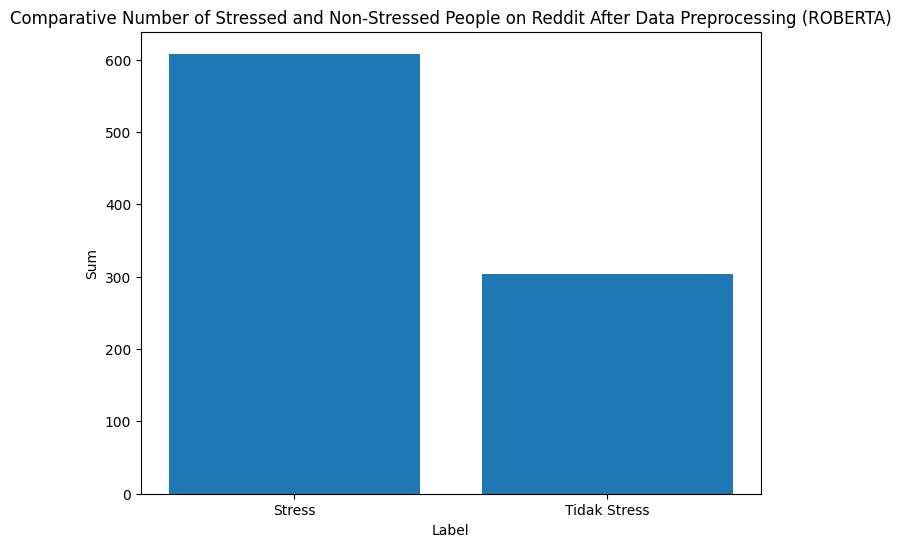

In [ ]:
plt.figure(figsize=(8, 6))
plt.bar(label_name, label_counts_2.values)
plt.xlabel('Label')
plt.ylabel('Sum')
plt.title('Comparative Number of Stressed and Non-Stressed People on Reddit After Data Preprocessing (ROBERTA)')
plt.show()

#### Histogram Visualization of Reddit Combi Data

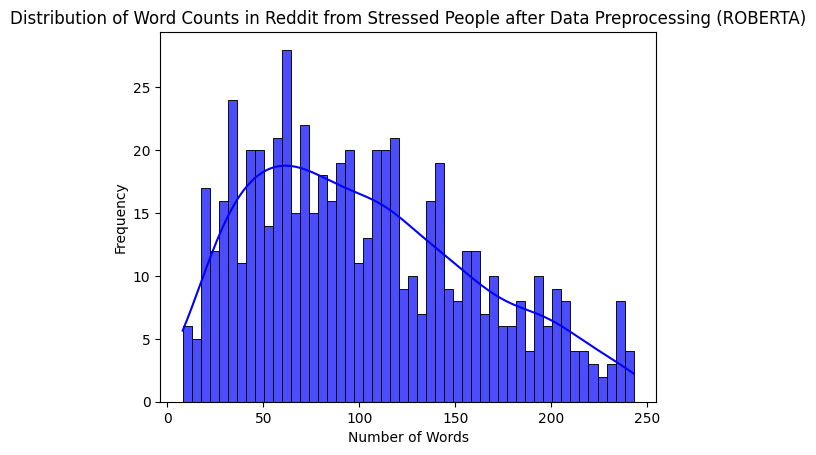

In [ ]:
teks_stress_reddit_roberta = reddit_model_final_roberta[reddit_model_final_roberta['label'] == 1]['body_title']
teks_stress_reddit_roberta = pd.DataFrame({'body_title': teks_stress_reddit_roberta})
teks_stress_reddit_roberta['text_length'] = teks_stress_reddit_roberta['body_title'].apply(lambda x: len(x.split()))
sns.histplot(teks_stress_reddit_roberta['text_length'], bins=50, color='blue',kde = True, alpha=0.7)
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts in Reddit from Stressed People after Data Preprocessing (ROBERTA)')
plt.show()


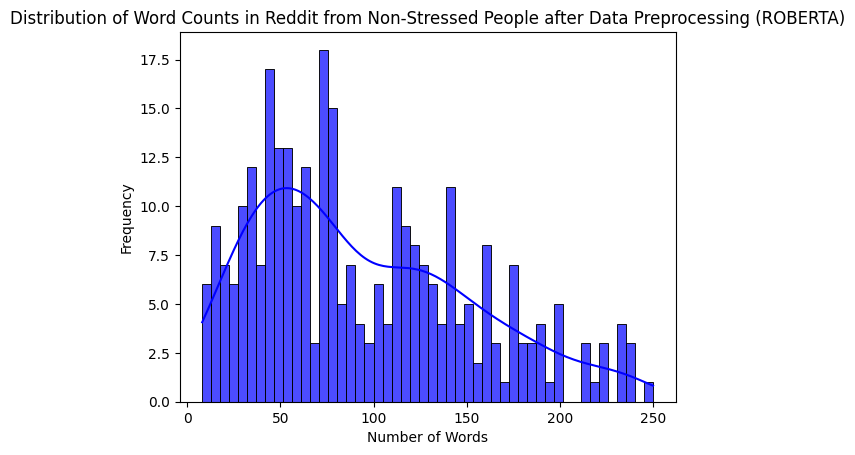

In [ ]:
teks_stress_no_reddit_roberta = reddit_model_final_roberta[reddit_model_final_roberta['label'] == 0]['body_title']
teks_stress_no_reddit_roberta = pd.DataFrame({'body_title': teks_stress_no_reddit_roberta})
teks_stress_no_reddit_roberta['text_length'] = teks_stress_no_reddit_roberta['body_title'].apply(lambda x: len(x.split()))
sns.histplot(teks_stress_no_reddit_roberta['text_length'], bins=50, color='blue', kde = True,alpha=0.7)
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts in Reddit from Non-Stressed People after Data Preprocessing (ROBERTA)')
plt.show()


#### Word Cloud of Reddit Combi Data

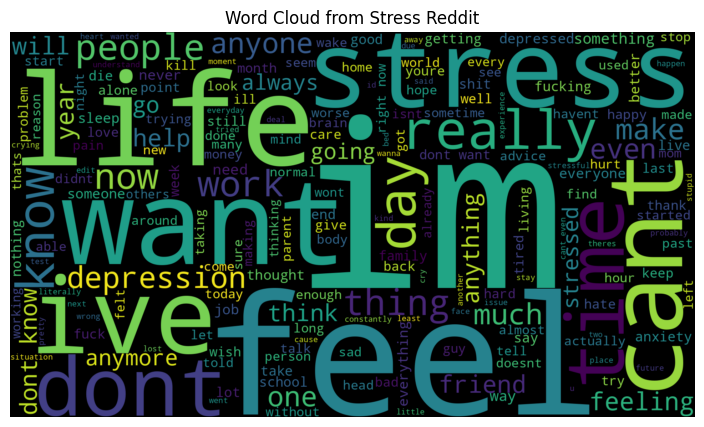

In [ ]:
reddit_prec_stress_roberta = ' '.join(reddit_model_final_roberta[reddit_model_final_roberta['label'] == 1]['body_title'])
wordcloud_prec_stress_roberta = WordCloud(
    background_color = 'black',
    height = 1080,
    width = 1920,
    stopwords = stopWords
)
wordcloud_prec_stress_roberta.generate(reddit_prec_stress_roberta)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_prec_stress_roberta, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud from Stress Reddit')
plt.show()

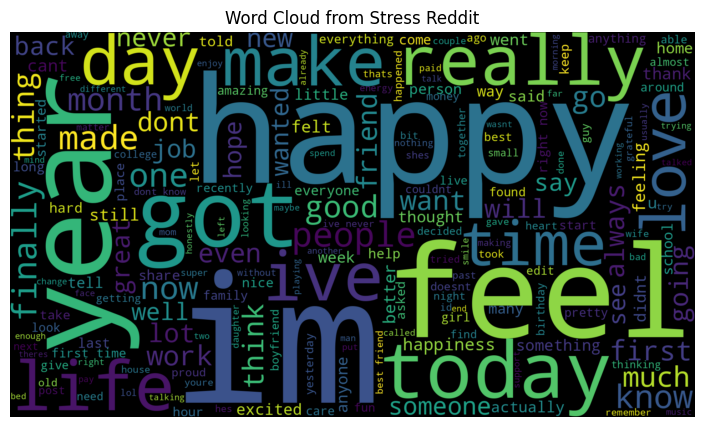

In [ ]:
reddit_prec_no_stress_roberta = ' '.join(reddit_model_final_roberta[reddit_model_final_roberta['label'] == 0]['body_title'])
wordcloud_no_prec_stress_roberta = WordCloud(
    background_color = 'black',
    height = 1080,
    width = 1920,
    stopwords = stopWords
)
wordcloud_no_prec_stress_roberta.generate(reddit_prec_no_stress_roberta)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_no_prec_stress_roberta, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud from Stress Reddit')
plt.show()

### Convert into Excel

In [ ]:
folder_path = '/content/output'
excel_file_name = 'reddit_model_roberta.xlsx'

In [ ]:
import os

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

In [ ]:
excel_file_path = os.path.join(folder_path, excel_file_name)

In [ ]:
twitter_model_bert.to_excel(excel_file_path, index=False)

### Train Test Split Using Undersampling Data For Reddit Combi ROBERTA

In [ ]:
train_x_reddit_model_roberta_us  = reddit_model_final_roberta ['body_title'].values
train_y_reddit_model_roberta_us  = reddit_model_final_roberta ['label'].values

In [ ]:
train_rc_x_roberta_us ,test_rc_x_roberta_us ,train_rc_y_roberta_us ,test_rc_y_roberta_us  = train_test_split(train_x_reddit_model_roberta_us ,train_y_reddit_model_roberta_us , test_size = .4,stratify = train_y_reddit_model_roberta_us , shuffle = True, random_state = 41)

In [ ]:
val_rc_x_roberta_us , test_rc_x_roberta_us , val_rc_y_roberta_us , test_rc_y_roberta_us  = train_test_split(test_rc_x_roberta_us , test_rc_y_roberta_us , test_size=0.5,stratify = test_rc_y_roberta_us , shuffle=True, random_state=42)

In [ ]:
ohe = preprocessing.OneHotEncoder()

train_rc_y_roberta_us  = ohe.fit_transform(np.array(train_rc_y_roberta_us).reshape(-1, 1)).toarray()
val_rc_y_roberta_us  = ohe.fit_transform(np.array(val_rc_y_roberta_us).reshape(-1, 1)).toarray()
test_rc_y_roberta_us  = ohe.fit_transform(np.array(test_rc_y_roberta_us).reshape(-1, 1)).toarray()

### Train Test Split Using Original Data For Reddit Combi ROBERTA

In [ ]:
train_x_reddit_model_roberta_ori  = reddit_model_roberta ['body_title'].values
train_y_reddit_model_roberta_ori  = reddit_model_roberta ['label'].values

In [ ]:
train_rc_x_roberta_ori ,test_rc_x_roberta_ori ,train_rc_y_roberta_ori ,test_rc_y_roberta_ori  = train_test_split(train_x_reddit_model_roberta_ori ,train_y_reddit_model_roberta_ori , test_size = .4,stratify = train_y_reddit_model_roberta_ori , shuffle = True, random_state = 41)
val_rc_x_roberta_ori , test_rc_x_roberta_ori , val_rc_y_roberta_ori , test_rc_y_roberta_ori  = train_test_split(test_rc_x_roberta_ori, test_rc_y_roberta_ori , test_size=0.5,stratify = test_rc_y_roberta_ori , shuffle=True, random_state=42)

In [ ]:
ohe = preprocessing.OneHotEncoder()

train_rc_y_roberta_ori  = ohe.fit_transform(np.array(train_rc_y_roberta_ori).reshape(-1, 1)).toarray()
val_rc_y_roberta_ori  = ohe.fit_transform(np.array(val_rc_y_roberta_ori).reshape(-1, 1)).toarray()
test_rc_y_roberta_ori  = ohe.fit_transform(np.array(test_rc_y_roberta_ori).reshape(-1, 1)).toarray()

### Train Test Split Using Oversampling Data For Reddit Combi ROBERTA

# **Modelling**

## Initialize BERT Model

In [ ]:
# BERT Model for Twt and Reddit
MAX_LEN= 256

In [ ]:
def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer_bert.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [ ]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
def create_model(bert_model, max_len=MAX_LEN):
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    accuracy = tf.keras.metrics.BinaryAccuracy()
    input_ids = tf.keras.Input(shape=(max_len,), dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,), dtype='int32')
    embeddings = bert_model([input_ids, attention_masks])[1]
    output = tf.keras.layers.Dense(2, activation="sigmoid")(embeddings)
    model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=output)
    model.compile(opt, loss=loss, metrics=[accuracy])
    return model


### For Twitter

In [ ]:
model_br_twitter = create_model(bert_model, MAX_LEN)
model_br_twitter.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256)]                0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 256)]                0         []                            
                                                                                                  
 tf_bert_model_1 (TFBertMod  TFBaseModelOutputWithPooli   1094822   ['input_3[0][0]',             
 el)                         ngAndCrossAttentions(last_   40         'input_4[0][0]']             
                             hidden_state=(None, 256, 7                                           
                             68),                                                           

### For Reddit

#### For Original Data

In [ ]:
model_br_reddit_ori = create_model(bert_model, MAX_LEN)
model_br_reddit_ori.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 256)]                0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 256)]                0         []                            
                                                                                                  
 tf_bert_model_1 (TFBertMod  TFBaseModelOutputWithPooli   1094822   ['input_5[0][0]',             
 el)                         ngAndCrossAttentions(last_   40         'input_6[0][0]']             
                             hidden_state=(None, 256, 7                                           
                             68),                                                           

#### For UnderSampling Data

In [ ]:
model_br_reddit_us = create_model(bert_model, MAX_LEN)
model_br_reddit_us.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 256)]                0         []                            
                                                                                                  
 input_8 (InputLayer)        [(None, 256)]                0         []                            
                                                                                                  
 tf_bert_model_1 (TFBertMod  TFBaseModelOutputWithPooli   1094822   ['input_7[0][0]',             
 el)                         ngAndCrossAttentions(last_   40         'input_8[0][0]']             
                             hidden_state=(None, 256, 7                                           
                             68),                                                           

#### For Oversampling Data

In [ ]:
model_br_reddit_over = create_model(bert_model, MAX_LEN)
model_br_reddit_over.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 256)]                0         []                            
                                                                                                  
 input_10 (InputLayer)       [(None, 256)]                0         []                            
                                                                                                  
 tf_bert_model_1 (TFBertMod  TFBaseModelOutputWithPooli   1094822   ['input_9[0][0]',             
 el)                         ngAndCrossAttentions(last_   40         'input_10[0][0]']            
                             hidden_state=(None, 256, 7                                           
                             68),                                                           

## Initialize ROBERTA Model

In [ ]:
def tokenize_roberta(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer_roberta.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [ ]:
def create_model_rb(roberta_model, max_len=MAX_LEN):
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    accuracy = tf.keras.metrics.BinaryAccuracy()
    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    output = roberta_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(2, activation=tf.nn.softmax)(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(opt, loss=loss, metrics=accuracy)
    return model

In [ ]:
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

### For Twitter

In [ ]:
model_rb_twitter = create_model_rb(roberta_model, MAX_LEN)
model_rb_twitter.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 256)]                0         []                            
                                                                                                  
 input_12 (InputLayer)       [(None, 256)]                0         []                            
                                                                                                  
 tf_roberta_model (TFRobert  TFBaseModelOutputWithPooli   1246456   ['input_11[0][0]',            
 aModel)                     ngAndCrossAttentions(last_   32         'input_12[0][0]']            
                             hidden_state=(None, 256, 7                                           
                             68),                                                           

### For Reddit

#### For Original Data

In [ ]:
model_rb_reddit_ori = create_model_rb(roberta_model, MAX_LEN)
model_rb_reddit_ori.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 256)]                0         []                            
                                                                                                  
 input_14 (InputLayer)       [(None, 256)]                0         []                            
                                                                                                  
 tf_roberta_model (TFRobert  TFBaseModelOutputWithPooli   1246456   ['input_13[0][0]',            
 aModel)                     ngAndCrossAttentions(last_   32         'input_14[0][0]']            
                             hidden_state=(None, 256, 7                                           
                             68),                                                           

#### For UnderSampling Data

In [ ]:
model_rb_reddit_us = create_model_rb(roberta_model, MAX_LEN)
model_rb_reddit_us.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 256)]                0         []                            
                                                                                                  
 input_16 (InputLayer)       [(None, 256)]                0         []                            
                                                                                                  
 tf_roberta_model (TFRobert  TFBaseModelOutputWithPooli   1246456   ['input_15[0][0]',            
 aModel)                     ngAndCrossAttentions(last_   32         'input_16[0][0]']            
                             hidden_state=(None, 256, 7                                           
                             68),                                                           

#### For Oversampling Data

In [ ]:
model_rb_reddit_over = create_model_rb(roberta_model, MAX_LEN)
model_rb_reddit_over.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 256)]                0         []                            
                                                                                                  
 input_18 (InputLayer)       [(None, 256)]                0         []                            
                                                                                                  
 tf_roberta_model (TFRobert  TFBaseModelOutputWithPooli   1246456   ['input_17[0][0]',            
 aModel)                     ngAndCrossAttentions(last_   32         'input_18[0][0]']            
                             hidden_state=(None, 256, 7                                           
                             68),                                                           

## Training using Twitter Dataset

### ROBERTA

In [ ]:
# RoBERTa Training using Twitter Dataset
train_input_ids_twitter_rb, train_attention_masks_twitter_rb = tokenize_roberta(train_twit_x_roberta, MAX_LEN)
val_input_ids_twitter_rb, val_attention_masks_twitter_rb = tokenize_roberta(val_twit_x_roberta, MAX_LEN)
test_input_ids_twitter_rb, test_attention_masks_twitter_rb = tokenize_roberta(test_twit_x_roberta, MAX_LEN)

In [ ]:
history_roberta_twitter = model_rb_twitter.fit([train_input_ids_twitter_rb,train_attention_masks_twitter_rb], train_twit_y_roberta, validation_data=([val_input_ids_twitter_rb,val_attention_masks_twitter_rb], val_twit_y_roberta), epochs=4, batch_size=16)

Epoch 1/4
74/74 [==============================] - 118s 1s/step - loss: 0.5824 - binary_accuracy: 0.6872 - val_loss: 0.3550 - val_binary_accuracy: 0.8426
Epoch 2/4
74/74 [==============================] - 72s 971ms/step - loss: 0.3584 - binary_accuracy: 0.8546 - val_loss: 0.2730 - val_binary_accuracy: 0.8858
Epoch 3/4
74/74 [==============================] - 71s 967ms/step - loss: 0.2568 - binary_accuracy: 0.8960 - val_loss: 0.3167 - val_binary_accuracy: 0.8680
Epoch 4/4
74/74 [==============================] - 71s 967ms/step - loss: 0.1776 - binary_accuracy: 0.9324 - val_loss: 0.3280 - val_binary_accuracy: 0.8985


### BERT

In [ ]:
# BERT Training using Twitter Dataset
train_input_ids_twitter, train_attention_masks_twitter = tokenize(train_twit_x_bert, MAX_LEN)
val_input_ids_twitter, val_attention_masks_twitter = tokenize(val_twit_x_bert, MAX_LEN)
test_input_ids_twitter, test_attention_masks_twitter = tokenize(test_twit_x_bert, MAX_LEN)

In [ ]:
history_bert_twitter = model_br_twitter.fit([train_input_ids_twitter,train_attention_masks_twitter], train_twit_y_bert, validation_data=([val_input_ids_twitter,val_attention_masks_twitter], val_twit_y_bert), epochs=4, batch_size=16)

Epoch 1/4
74/74 [==============================] - 117s 1s/step - loss: 0.6033 - binary_accuracy: 0.6746 - val_loss: 0.4697 - val_binary_accuracy: 0.7995
Epoch 2/4
74/74 [==============================] - 71s 967ms/step - loss: 0.3852 - binary_accuracy: 0.8470 - val_loss: 0.3930 - val_binary_accuracy: 0.8414
Epoch 3/4
74/74 [==============================] - 71s 965ms/step - loss: 0.2579 - binary_accuracy: 0.9011 - val_loss: 0.3391 - val_binary_accuracy: 0.8401
Epoch 4/4
74/74 [==============================] - 71s 963ms/step - loss: 0.1287 - binary_accuracy: 0.9552 - val_loss: 0.4250 - val_binary_accuracy: 0.8515


## Training using Reddit Dataset

### ROBERTA

#### Original Data

In [ ]:
# ROBERTA Training using Reddit Dataset
train_input_ids_reddit_rb_ori, train_attention_masks_reddit_rb_ori = tokenize_roberta(train_rc_x_roberta_ori, MAX_LEN)
val_input_ids_reddit_rb_ori, val_attention_masks_reddit_rb_ori = tokenize_roberta(val_rc_x_roberta_ori, MAX_LEN)
test_input_ids_reddit_rb_ori, test_attention_masks_reddit_rb_ori = tokenize_roberta(test_rc_x_roberta_ori, MAX_LEN)

In [ ]:
history_roberta_reddit_ori = model_rb_reddit_ori.fit([train_input_ids_reddit_rb_ori,train_attention_masks_reddit_rb_ori], train_rc_y_roberta_ori, validation_data=([val_input_ids_reddit_rb_ori,val_attention_masks_reddit_rb_ori], val_rc_y_roberta_ori), epochs=4, batch_size=16)

Epoch 1/4
94/94 [==============================] - 136s 1s/step - loss: 0.2003 - binary_accuracy: 0.9170 - val_loss: 0.1246 - val_binary_accuracy: 0.9618
Epoch 2/4
94/94 [==============================] - 89s 950ms/step - loss: 0.0941 - binary_accuracy: 0.9705 - val_loss: 0.1590 - val_binary_accuracy: 0.9598
Epoch 3/4
94/94 [==============================] - 89s 953ms/step - loss: 0.0526 - binary_accuracy: 0.9833 - val_loss: 0.1391 - val_binary_accuracy: 0.9618
Epoch 4/4
94/94 [==============================] - 90s 955ms/step - loss: 0.0267 - binary_accuracy: 0.9900 - val_loss: 0.1708 - val_binary_accuracy: 0.9618


#### UnderSampling Data

In [ ]:
# ROBERTA Training using Reddit Dataset
train_input_ids_reddit_rb_us, train_attention_masks_reddit_rb_us = tokenize_roberta(train_rc_x_roberta_us, MAX_LEN)
val_input_ids_reddit_rb_us, val_attention_masks_reddit_rb_us = tokenize_roberta(val_rc_x_roberta_us, MAX_LEN)
test_input_ids_reddit_rb_us, test_attention_masks_reddit_rb_us = tokenize_roberta(test_rc_x_roberta_us, MAX_LEN)

In [ ]:
history_roberta_reddit_us = model_rb_reddit_us.fit([train_input_ids_reddit_rb_us,train_attention_masks_reddit_rb_us], train_rc_y_roberta_us, validation_data=([val_input_ids_reddit_rb_us,val_attention_masks_reddit_rb_us], val_rc_y_roberta_us), epochs=4, batch_size=16)

Epoch 1/4
35/35 [==============================] - 79s 1s/step - loss: 0.2823 - binary_accuracy: 0.8592 - val_loss: 0.0939 - val_binary_accuracy: 0.9725
Epoch 2/4
35/35 [==============================] - 35s 1s/step - loss: 0.0919 - binary_accuracy: 0.9653 - val_loss: 0.0675 - val_binary_accuracy: 0.9780
Epoch 3/4
35/35 [==============================] - 35s 990ms/step - loss: 0.0387 - binary_accuracy: 0.9945 - val_loss: 0.0675 - val_binary_accuracy: 0.9835
Epoch 4/4
35/35 [==============================] - 34s 985ms/step - loss: 0.0349 - binary_accuracy: 0.9872 - val_loss: 0.0983 - val_binary_accuracy: 0.9780


#### OverSampling Data

### BERT

#### Original Data

In [ ]:
# BERT Training using Reddit Dataset
train_input_ids_reddit_bert_ori, train_attention_masks_reddit_bert_ori = tokenize(train_rc_x_bert_ori, MAX_LEN)
val_input_ids_reddit_bert_ori, val_attention_masks_reddit_bert_ori = tokenize(val_rc_x_bert_ori, MAX_LEN)
test_input_ids_reddit_bert_ori, test_attention_masks_reddit_bert_ori = tokenize(test_rc_x_bert_ori, MAX_LEN)

In [ ]:
history_bert_reddit_ori = model_br_reddit_ori.fit([train_input_ids_reddit_bert_ori,train_attention_masks_reddit_bert_ori], train_rc_y_bert_ori, validation_data=([val_input_ids_reddit_bert_ori,val_attention_masks_reddit_bert_ori], val_rc_y_bert_ori), epochs=4, batch_size=16)

Epoch 1/4
93/93 [==============================] - 131s 990ms/step - loss: 0.2223 - binary_accuracy: 0.9180 - val_loss: 0.1730 - val_binary_accuracy: 0.9433
Epoch 2/4
93/93 [==============================] - 88s 950ms/step - loss: 0.0872 - binary_accuracy: 0.9717 - val_loss: 0.2079 - val_binary_accuracy: 0.9211
Epoch 3/4
93/93 [==============================] - 88s 949ms/step - loss: 0.0327 - binary_accuracy: 0.9922 - val_loss: 0.2148 - val_binary_accuracy: 0.9393
Epoch 4/4
93/93 [==============================] - 88s 948ms/step - loss: 0.0079 - binary_accuracy: 0.9993 - val_loss: 0.2589 - val_binary_accuracy: 0.9413


#### Undersampling Data

In [ ]:
# BERT Training using Reddit Dataset
train_input_ids_reddit_bert_us, train_attention_masks_reddit_bert_us = tokenize(train_rc_x_bert_us, MAX_LEN)
val_input_ids_reddit_bert_us, val_attention_masks_reddit_bert_us = tokenize(val_rc_x_bert_us, MAX_LEN)
test_input_ids_reddit_bert_us, test_attention_masks_reddit_bert_us = tokenize(test_rc_x_bert_us, MAX_LEN)

In [ ]:
history_bert_reddit_us = model_br_reddit_us.fit([train_input_ids_reddit_bert_us,train_attention_masks_reddit_bert_us], train_rc_y_bert_us, validation_data=([val_input_ids_reddit_bert_us,val_attention_masks_reddit_bert_us], val_rc_y_bert_us), epochs=4, batch_size=16)

Epoch 1/4
35/35 [==============================] - 76s 1s/step - loss: 0.2963 - binary_accuracy: 0.9284 - val_loss: 0.1239 - val_binary_accuracy: 0.9725
Epoch 2/4
35/35 [==============================] - 32s 922ms/step - loss: 0.1092 - binary_accuracy: 0.9752 - val_loss: 0.1146 - val_binary_accuracy: 0.9725
Epoch 3/4
35/35 [==============================] - 34s 970ms/step - loss: 0.0617 - binary_accuracy: 0.9872 - val_loss: 0.1062 - val_binary_accuracy: 0.9780
Epoch 4/4
35/35 [==============================] - 34s 974ms/step - loss: 0.0565 - binary_accuracy: 0.9835 - val_loss: 0.0856 - val_binary_accuracy: 0.9725


#### Oversampling Data

# **Evaluation**

## Evaluation Function

In [ ]:
#Conf Matrix
def conf_matrix(y, y_pred, title):
    fig, ax =plt.subplots(figsize=(5,5))
    labels=[0,1]
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17)
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Test', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)
    plt.show()

## BERT Evaluation using Twitter Dataset

In [ ]:
result_bert_twitter = model_br_twitter.predict([test_input_ids_twitter,test_attention_masks_twitter])

13/13 [==============================] - 7s 541ms/step


In [ ]:
y_pred_bert_twit =  np.zeros_like(result_bert_twitter)
y_pred_bert_twit[np.arange(len(y_pred_bert_twit)), result_bert_twitter.argmax(1)] = 1

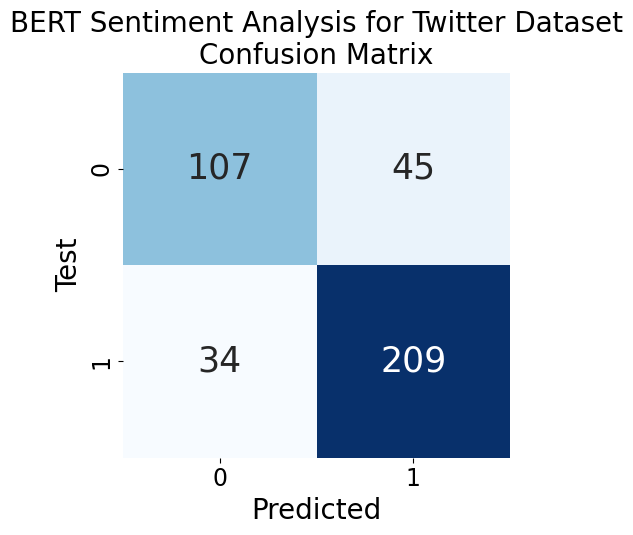

In [ ]:
conf_matrix(test_twit_y_bert.argmax(1), y_pred_bert_twit.argmax(1),'BERT Sentiment Analysis for Twitter Dataset\nConfusion Matrix')

In [ ]:
# BERT precision, recall, f1-score, accuracy
print(classification_report(test_twit_y_bert.argmax(1), y_pred_bert_twit.argmax(1)))

              precision    recall  f1-score   support

           0       0.76      0.70      0.73       152
           1       0.82      0.86      0.84       243

    accuracy                           0.80       395
   macro avg       0.79      0.78      0.79       395
weighted avg       0.80      0.80      0.80       395



## RoBERTa Evaluation using Twitter Dataset

In [ ]:
result_roberta_twitter = model_rb_twitter.predict([test_input_ids_twitter_rb,test_attention_masks_twitter_rb])

13/13 [==============================] - 7s 506ms/step


In [ ]:
y_pred_roberta_twit =  np.zeros_like(result_roberta_twitter)
y_pred_roberta_twit[np.arange(len(y_pred_roberta_twit)), result_roberta_twitter.argmax(1)] = 1

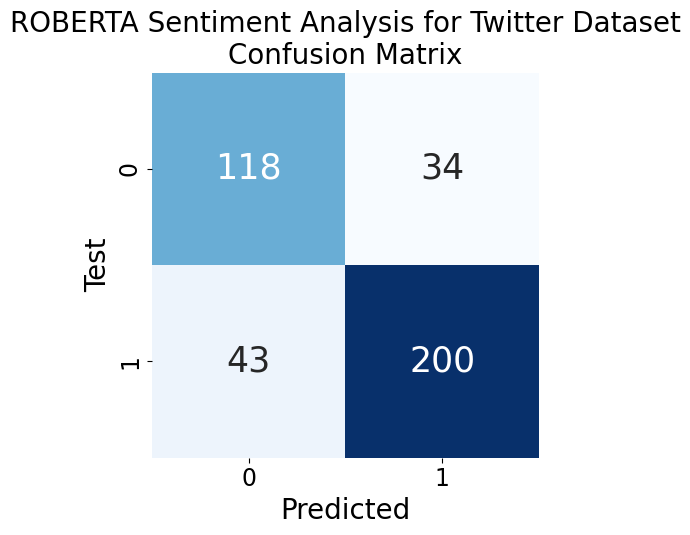

In [ ]:
# RoBERTa Conf Matrix
conf_matrix(test_twit_y_roberta.argmax(1), y_pred_roberta_twit.argmax(1),'ROBERTA Sentiment Analysis for Twitter Dataset\nConfusion Matrix')

In [ ]:
# RoBERTa precision, recall, f1-score, accuracy
print(classification_report(test_twit_y_roberta.argmax(1), y_pred_roberta_twit.argmax(1)))

              precision    recall  f1-score   support

           0       0.73      0.78      0.75       152
           1       0.85      0.82      0.84       243

    accuracy                           0.81       395
   macro avg       0.79      0.80      0.80       395
weighted avg       0.81      0.81      0.81       395



## BERT Evaluation using Reddit Dataset

### Original Data

In [ ]:
result_bert_reddit_ori = model_br_reddit_ori.predict([test_input_ids_reddit_bert_ori,test_attention_masks_reddit_bert_ori])

16/16 [==============================] - 9s 550ms/step


In [ ]:
y_pred_bert_reddit_ori =  np.zeros_like(result_bert_reddit_ori)
y_pred_bert_reddit_ori[np.arange(len(y_pred_bert_reddit_ori)), result_bert_reddit_ori.argmax(1)] = 1

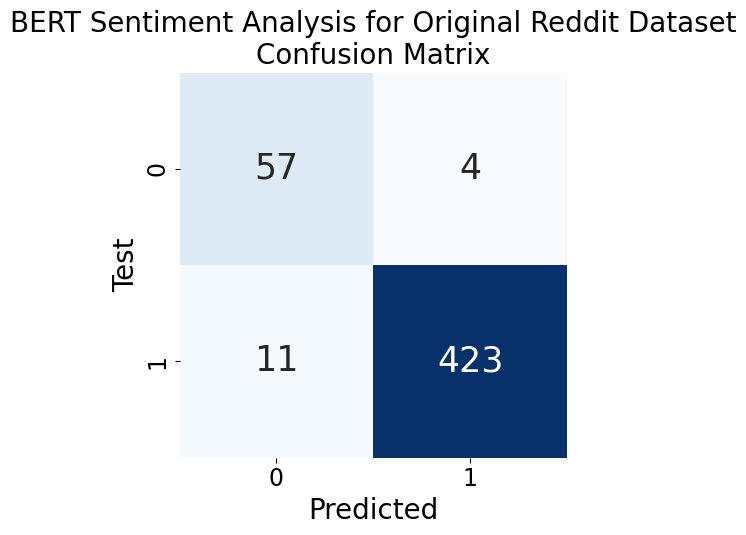

In [ ]:
conf_matrix(test_rc_y_bert_ori.argmax(1),y_pred_bert_reddit_ori.argmax(1),'BERT Sentiment Analysis for Original Reddit Dataset\nConfusion Matrix')

In [ ]:
# BERT precision, recall, f1-score, accuracy
print(classification_report(test_rc_y_bert_ori.argmax(1), y_pred_bert_reddit_ori.argmax(1)))

              precision    recall  f1-score   support

           0       0.84      0.93      0.88        61
           1       0.99      0.97      0.98       434

    accuracy                           0.97       495
   macro avg       0.91      0.95      0.93       495
weighted avg       0.97      0.97      0.97       495



### UnderSampling Data

In [ ]:
result_bert_reddit_us = model_br_reddit_us.predict([test_input_ids_reddit_bert_us,test_attention_masks_reddit_bert_us])

6/6 [==============================] - 3s 546ms/step


In [ ]:
y_pred_bert_reddit_us =  np.zeros_like(result_bert_reddit_us)
y_pred_bert_reddit_us[np.arange(len(y_pred_bert_reddit_us)), result_bert_reddit_us.argmax(1)] = 1

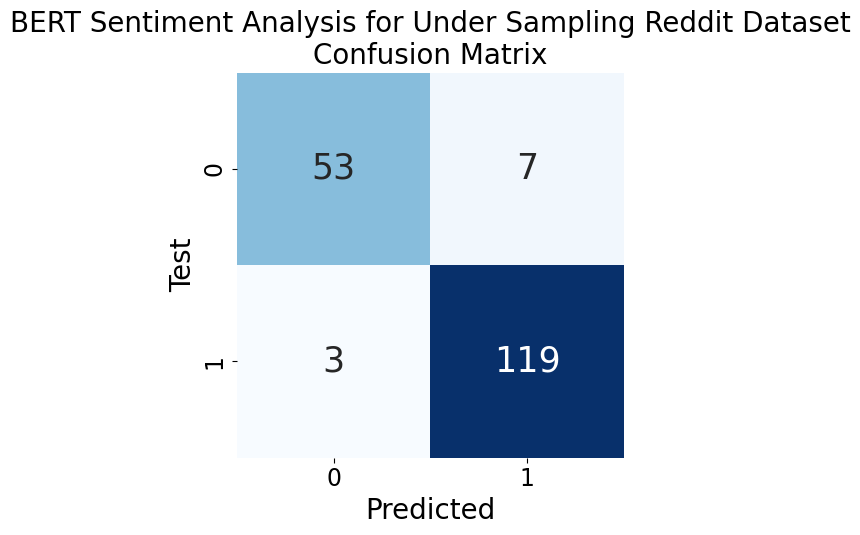

In [ ]:
conf_matrix(test_rc_y_bert_us.argmax(1), y_pred_bert_reddit_us.argmax(1),'BERT Sentiment Analysis for Under Sampling Reddit Dataset\nConfusion Matrix')

In [ ]:
# BERT precision, recall, f1-score, accuracy
print(classification_report(test_rc_y_bert_us.argmax(1), y_pred_bert_reddit_us.argmax(1)))

              precision    recall  f1-score   support

           0       0.95      0.88      0.91        60
           1       0.94      0.98      0.96       122

    accuracy                           0.95       182
   macro avg       0.95      0.93      0.94       182
weighted avg       0.95      0.95      0.94       182



## RoBERTa Evaluation using Reddit Dataset

### Original Data

In [ ]:
result_roberta_reddit_ori = model_rb_reddit_ori.predict([test_input_ids_reddit_rb_ori,test_attention_masks_reddit_rb_ori])

16/16 [==============================] - 9s 539ms/step


In [ ]:
y_pred_roberta_reddit_ori =  np.zeros_like(result_roberta_reddit_ori)
y_pred_roberta_reddit_ori[np.arange(len(y_pred_roberta_reddit_ori)), result_roberta_reddit_ori.argmax(1)] = 1

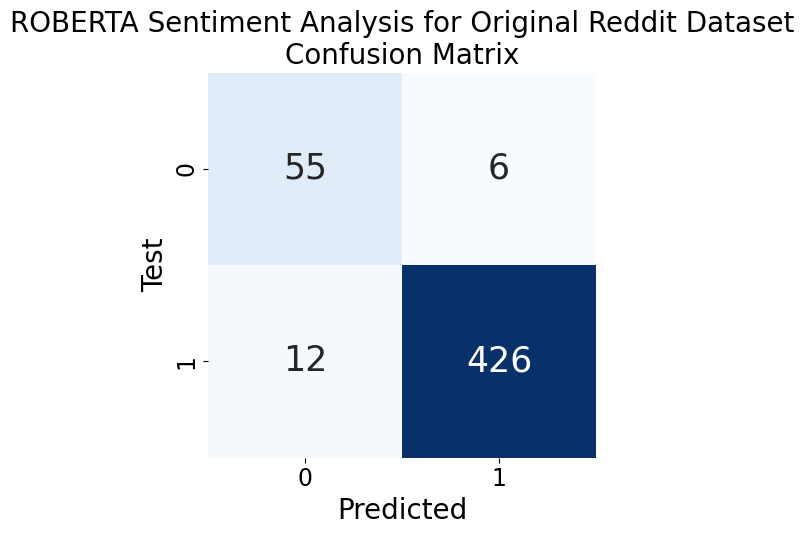

In [ ]:
# ROBERTA Conf Matrix
conf_matrix(test_rc_y_roberta_ori.argmax(1), y_pred_roberta_reddit_ori.argmax(1),'ROBERTA Sentiment Analysis for Original Reddit Dataset\nConfusion Matrix')

In [ ]:
# ROBERTA precision, recall, f1-score, accuracy
print(classification_report(test_rc_y_roberta_ori.argmax(1), y_pred_roberta_reddit_ori.argmax(1)))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86        61
           1       0.99      0.97      0.98       438

    accuracy                           0.96       499
   macro avg       0.90      0.94      0.92       499
weighted avg       0.97      0.96      0.96       499



### UnderSampling Data

In [ ]:
result_roberta_reddit_us = model_rb_reddit_us.predict([test_input_ids_reddit_rb_us,test_attention_masks_reddit_rb_us])

6/6 [==============================] - 3s 533ms/step


In [ ]:
y_pred_roberta_reddit_us =  np.zeros_like(result_roberta_reddit_us)
y_pred_roberta_reddit_us[np.arange(len(y_pred_roberta_reddit_us)), result_roberta_reddit_us.argmax(1)] = 1

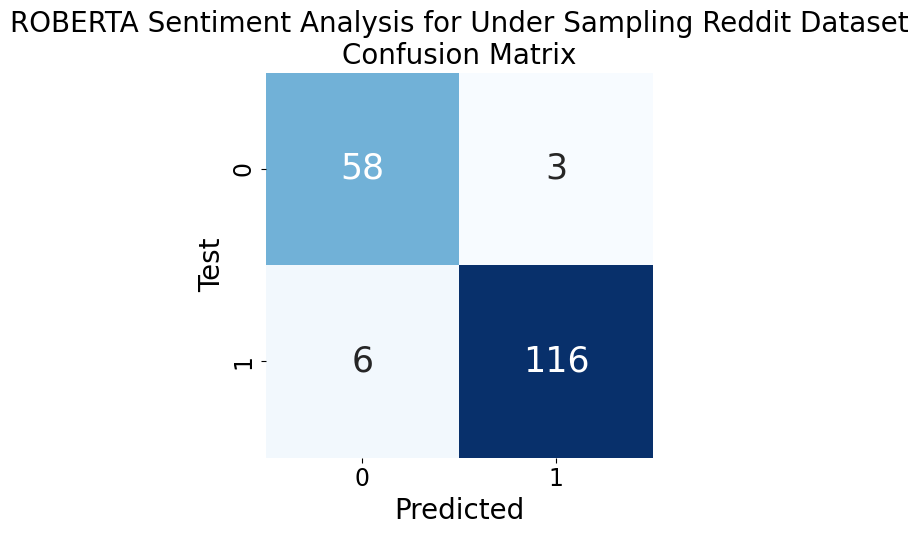

In [ ]:
# ROBERTA Conf Matrix
conf_matrix(test_rc_y_roberta_us.argmax(1), y_pred_roberta_reddit_us.argmax(1),'ROBERTA Sentiment Analysis for Under Sampling Reddit Dataset\nConfusion Matrix')

In [ ]:
# ROBERTA precision, recall, f1-score, accuracy
print(classification_report(test_rc_y_roberta_us.argmax(1), y_pred_roberta_reddit_us.argmax(1)))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93        61
           1       0.97      0.95      0.96       122

    accuracy                           0.95       183
   macro avg       0.94      0.95      0.95       183
weighted avg       0.95      0.95      0.95       183



# **Feedback**

Melalui hasil penelitian ini, dapat dilihat bahwa algoritma RoBERTa berhasil mendapatkan nilai akurasi yang lebih tinggi daripada algoritma BERT pada dataset Twitter. Di sisi lain, pada dataset Reddit dapat dilihat bahwa algoritma RoBERTa dan BERT mendapatkan akurasi yang seimbang. Melalui hasil perbandingan akurasi tersebut, dapat disimpulkan bahwa algoritma RoBERTa merupakan algoritma yang tepat untuk melakukan deteksi dini pada stres dari postingan di media sosial. Namun penting untuk dicatat bahwa akurasi yang dicapai dapat bervariasi tergantung pada kumpulan data yang digunakan dan modifikasi arsitektur RoBERTa yang digunakan.

# **Dashboard**

# **Referensi**

https://www.tensorflow.org/api_docs/python/tf

https://huggingface.co/docs/transformers/model_doc/bert

https://huggingface.co/docs/transformers/model_doc/roberta

https://www.kaggle.com/code/ludovicocuoghi/twitter-sentiment-analysis-with-bert-vs-roberta?scriptVersionId=83046050 
